# Names of Project Members

## 1) Aamir Ahmad Andari
## 2) Ibtisam
## 3) Sparsh
## 4) Faisal

# 1. Problem Statement

### Prediction between the hurricane damaged and non-damaged properties and areas using satellite images. The aim was to identify the damaged buildings as to reduce the time to identify places casualities might have taken place.

# 2. Approcah 
### We propose two aprroaches to solve this problem:
### a) Build a CNN from scratch
### b) Build a model using SOTA through Transfer learning

# 2.1 Part A: Build a CNN from scratch
### We propose a CNN network and building it from scratch. The clarity of the images was not great so we used Data Augmentation to get as much as the gist of the data as increasing the resolution needs a new neural network which is for now out of the scope.

In [3]:
# For GENERATING INFERENCE MAPS 
!pip3 -qq install tf_keras_vis 

Importing all the basic libraries before hand and other shall be found inside their code block

In [1]:
import numpy as np
from PIL import Image
from scipy.signal import convolve2d
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import model_from_json
%matplotlib inline

# 2.1.1 Data Preparation
## We prepare and load our data from the directories using keras's ImageDamaGenerator, we only use few basic transformation as the image clearity is low, we only try the variations that we think might benefit us. 

In [5]:
datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,rotation_range=90,zoom_range=[0.2,1],vertical_flip=True)

In [6]:
train_dir='/kaggle/input/satellite-images-of-hurricane-damage/train_another'

In [7]:
traingen=datagen.flow_from_directory(train_dir,target_size=(128,128),class_mode='binary',batch_size=256,subset='training')

Found 10000 images belonging to 2 classes.


In [8]:
val_dir='/kaggle/input/satellite-images-of-hurricane-damage/validation_another'

## Validation data is only subjected to normalization of pixels by rescaling them.

In [9]:
datagen2=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [10]:
valgen=datagen2.flow_from_directory(val_dir,target_size=(128,128),class_mode='binary',batch_size=256)

Found 2000 images belonging to 2 classes.


In [11]:
testgen=datagen2.flow_from_directory('/kaggle/input/satellite-images-of-hurricane-damage/test',class_mode='binary',target_size=(128,128),batch_size=256)

Found 2000 images belonging to 2 classes.


In [12]:
testgen2=datagen2.flow_from_directory('/kaggle/input/satellite-images-of-hurricane-damage/test_another',class_mode='binary',target_size=(128,128),batch_size=256)

Found 9000 images belonging to 2 classes.


# 2.1.2 Model Architecture 
## ***The proposed model architecture, we have 5 convolution layers starting with a kernel size of 5 and 128 filters for first two layers and then reducing the filters and kernel size. We start with 5 filters to have a larger receptive field and take maximum information of the surroundings. Max Pooling layers are used to reduce the dimensions of the feature maps. 2 dense layers with 400 neurons are used. Relu is the prefered activation used in the convolution layers as well as the dense layers. A single neuron dense layer with sigmoid activation is used for output.*** 

## ***Dropout has been taken as the preferred regularization technique with 0.3 as the drop out ratio. Batchnormalization has not been taken in account as well as Norm Regularization. BatchNorm had an adverse affect when added on dense and convolution layers seperately.***

In [88]:
#NN From Scracth 

#MOdel1

inputs=tf.keras.Input((128,128,3))
#Initial Layers of 256 Filters 
x=tf.keras.layers.Conv2D(128,5,padding='same')(inputs)
x=tf.keras.layers.Activation(activation='relu')(x)
x=tf.keras.layers.Conv2D(128,5,padding='same')(x)
x=tf.keras.layers.Activation(activation='relu')(x)
x=tf.keras.layers.Conv2D(64,5,padding='same')(x)
x=tf.keras.layers.Activation(activation='relu')(x)

#MAx Pool
x=tf.keras.layers.MaxPool2D(strides=(2,2))(x)

#Decreasing Filters and MAxPool Layers
x=tf.keras.layers.Conv2D(64,3,padding='same')(x)
x=tf.keras.layers.Activation(activation='relu')(x)
x=tf.keras.layers.MaxPool2D(strides=(2,2))(x)
x=tf.keras.layers.Conv2D(8,3,padding='same')(x)
x=tf.keras.layers.Activation(activation='relu')(x)
x=tf.keras.layers.MaxPool2D(strides=(2,2))(x)

#Dense Layers 
x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(400)(x)
x=tf.keras.layers.Dropout(0.3)(x)
x=tf.keras.layers.Activation(activation='relu')(x)
x=tf.keras.layers.Dense(400)(x)
x=tf.keras.layers.Dropout(0.3)(x)
x=tf.keras.layers.Activation(activation='relu')(x)
x=tf.keras.layers.Dense(1)(x)

#Output
out=tf.keras.layers.Activation(activation='sigmoid')(x)

model=tf.keras.Model(inputs,out,name='BaseModel')
model.summary()


Model: "BaseModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 128)     9728      
_________________________________________________________________
activation_8 (Activation)    (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 128)     409728    
_________________________________________________________________
activation_9 (Activation)    (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 64)      204864    
_________________________________________________________________
activation_10 (Activation)   (None, 128, 128, 64)      0 

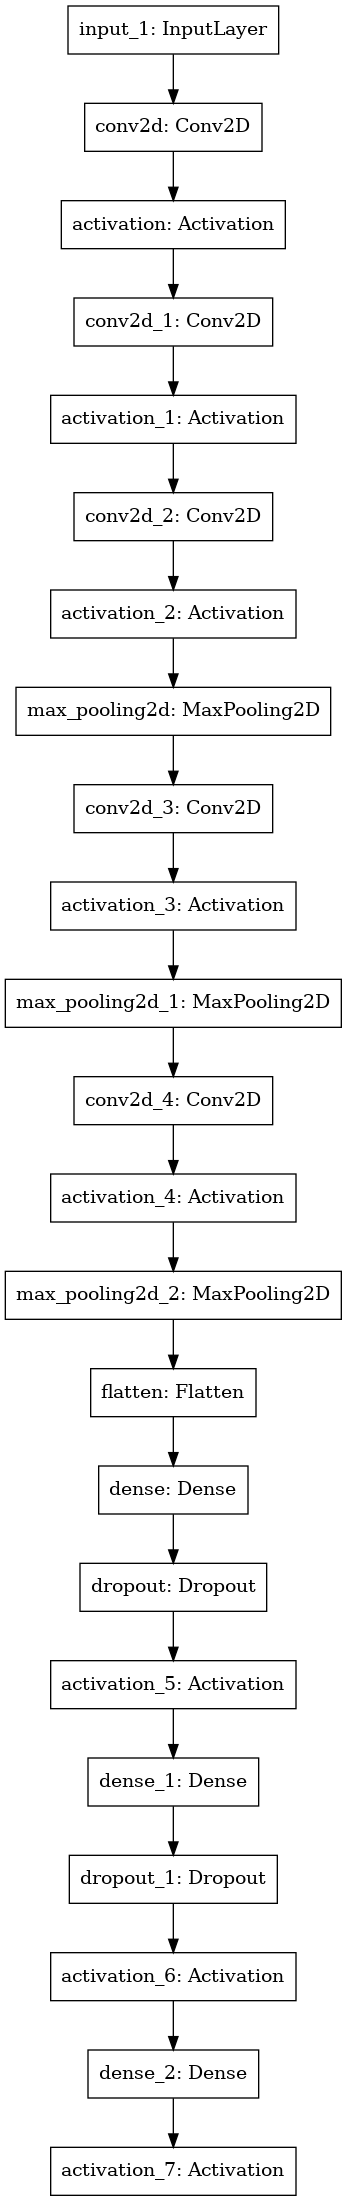

In [14]:
tf.keras.utils.plot_model(model,'model.png')

# 2.1.3 Model Compilation & Training 
### *Due to limited resources the model architecture couldn't be deeper as it already takes 10.82GB space of the allotted 11GB in Google Colab and 15GB  GPU memory in Kaggle Code.* 
### *We trained first time with 20 epochs , saved the weights and again with 10 epochs in another session by loading the previously saved weights with a learning rate of 0.001 and Adam Optimizer. We again train for further 5 epochs by decreasing the learning rate by a factor of 10, learning rate=0.0001. In the first 20 epochs we achieved a validation accuracy of 0.90 and for the next 10 epochs we reached a validation accuraxy of 0.92 but we noticed that the loss was not decreasing at but bouncing may be the learning rate was a bit large for the gradient plane and hence the reduced learning rate was used in the next 5 training epochs which saw a steadier decrease in loss.*

## 2.1.3.1 Model With 20 Training Epochs

#### Loading Our trained model. The code to save and load the model through out the notebook is inspired from kaggle Question and Answers

In [15]:
json_file = open('/kaggle/input/mymodel/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights('/kaggle/input/mymodel/model.h5')
print("Loaded model from disk")

Loaded model from disk


#### This is our base model with 20 epochs and all the models we propose next weather a result of more trianing or a different technique shall be compared to this model. We have commented the model fit commands as to not run accidently the training procedure again.

In [16]:
loaded_model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

### *Model was trained over 20 epochs and saved, this code below was used to train the model and save it's training history to a variable history_basic, the plots were saved and the output was discarded by the quick save in kaggle.* 

In [ ]:
# history_basic=model.fit(traingen,validation_data=valgen,epochs=20,steps_per_epoch=40,validation_steps=8)

In [ ]:
##THE CODE USED TO SAVE OUR MODELS ##

# model_json = loaded_model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# loaded_model.save_weights("model.h5")
# print("Saved model to disk")

#### Due training our model again we couldn't maintain the history in a variable but we stored the images and the images as well as their generator codes are given below

In [ ]:
plt.plot(history_basic1.history['loss'],label='Train Loss', color='#051e3e',linewidth=1.5)
plt.plot(history_basic1.history['val_loss'],label='Validation Loss', color='#851e3e',linewidth=1.5)
plt.xlabel('EPOCHS',fontsize=40, color='black',)
plt.ylabel('LOSS',fontsize=40, color='black')
plt.xticks(fontsize=28,rotation=60)
plt.yticks(fontsize=30)
plt.ticklabel_format(style='plain', axis='y')
plt.grid(True,color='black',alpha=0.1)
plt.title("CNN LOSS PLOT",fontsize=40, color='black')
plt.legend(loc=0,borderpad=1,fontsize=25)
plt.tight_layout()
plt.savefig('LOSS.jpeg')

(-0.5, 1079.5, 719.5, -0.5)

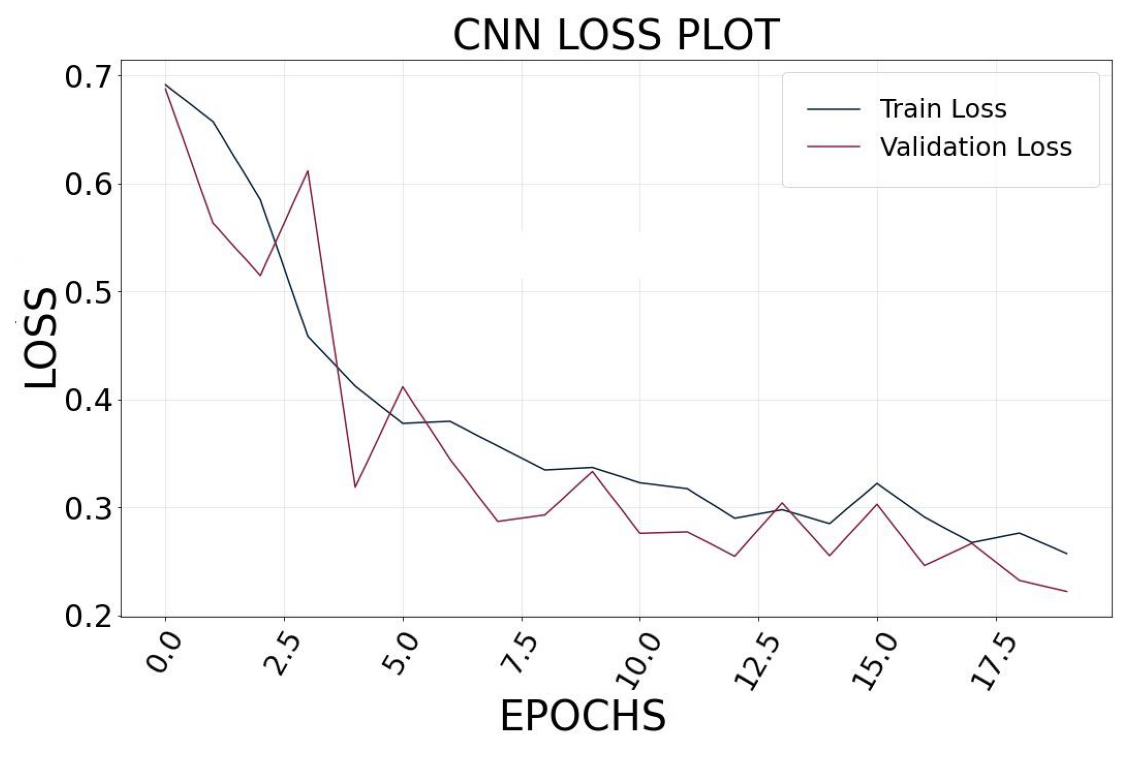

In [17]:
img=Image.open('/kaggle/input/loss-and-accuracy-plots/LOSS.jpeg')
fig,ax=plt.subplots(figsize=(20,15))
ax.imshow(img)
ax.axis('off')

In [ ]:
plt.plot(history_basic1.history['accuracy'],label='Train', color='#051e3e',linewidth=2)
plt.plot(history_basic1.history['val_accuracy'],label='Validation', color='#851e3e',linewidth=2)
plt.xlabel('EPOCHS',fontsize=40, color='black',)
plt.ylabel('Accuracy',fontsize=40, color='black')
plt.xticks(fontsize=28,rotation=60)
plt.yticks(fontsize=30)
plt.ticklabel_format(style='plain', axis='y')
plt.grid(True,color='black',alpha=0.1)
plt.title("CNN ACCURACY PLOT",fontsize=40, color='black')
plt.legend(loc=0,borderpad=1,fontsize=25)
plt.tight_layout()
plt.savefig('ACCURACY.jpeg')

(-0.5, 1079.5, 719.5, -0.5)

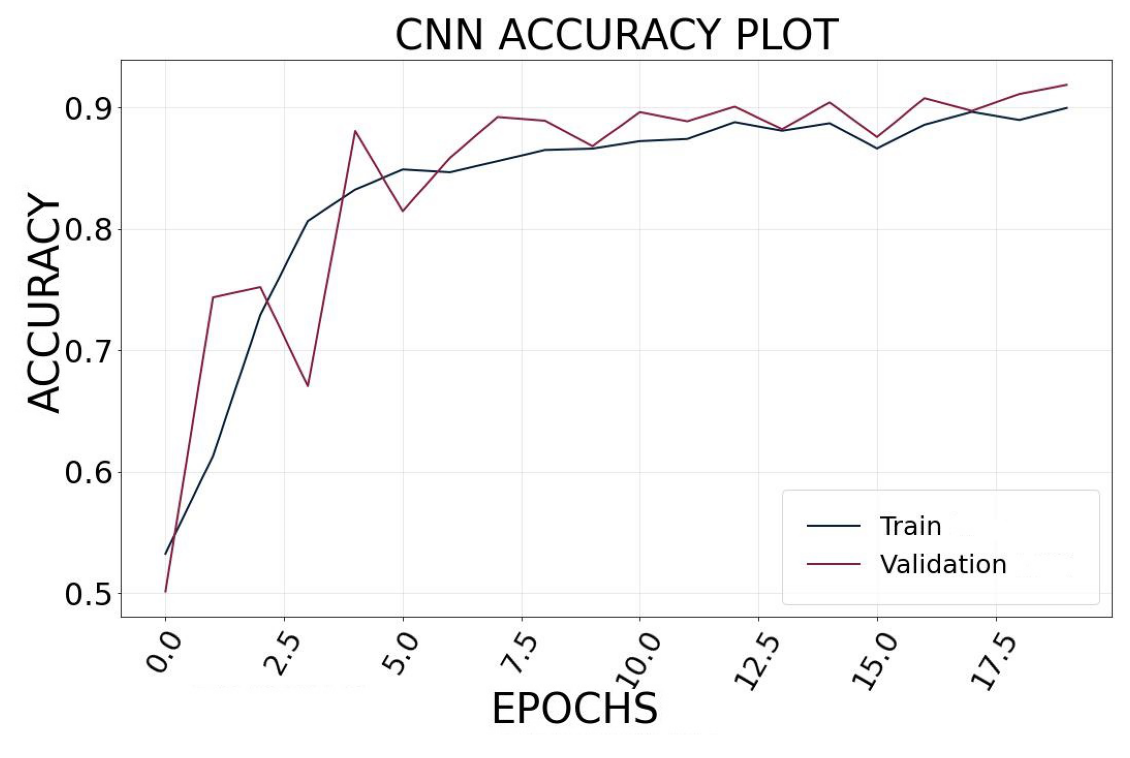

In [18]:
img=Image.open('/kaggle/input/loss-and-accuracy-plots/ACCURACY.jpeg')
fig,ax=plt.subplots(figsize=(20,15))
ax.imshow(img)
ax.axis('off')

# 2.1.4 MODEL EVALUATION AND INFERENCES

In [19]:
loaded_model.evaluate(valgen)

2021-12-14 09:24:05.548116: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-14 09:24:06.945432: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


8/8 [==============================] - 43s 3s/step - loss: 0.2220 - accuracy: 0.9185


[0.22202225029468536, 0.9185000061988831]

In [20]:
loaded_model.evaluate(testgen)

8/8 [==============================] - 8s 1s/step - loss: 0.2421 - accuracy: 0.9085


[0.24206019937992096, 0.9085000157356262]

In [21]:
loaded_model.evaluate(testgen2)

36/36 [==============================] - 39s 1s/step - loss: 0.2281 - accuracy: 0.9261


[0.22813867032527924, 0.926111102104187]

### The Accuracy for validation data with equal classes is 0.9185
### The Accuracy for test data with equal classes is 0.9085
### The Accuracy for validation data with equal classes is 0.9261

## 2.1.4.2 INFERENCE FROM BASE MODEL

## WE WILL RANDOMLY SELECT THE IMAGES AND FIND OUT IF OUR MODEL HAS CORRECTLY OR INCORRECTLY IDENTIFIED THE CLASSES. WE WILL FURTHER INVESTIGATE WHY AND WHAT MIGHT HAVE LEAD TO THAT RESULTS.

## FOR THIS TASK WE WILL USE FEATURE MAPS INVESTIGATION AND HEATMAPS GENERATED USING GRADCAMPLUS 


The prediction by model is 0.07999999821186066
[[False]]


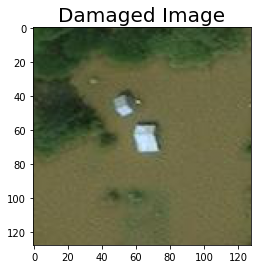

In [22]:
img1=Image.open('/kaggle/input/satellite-images-of-hurricane-damage/test_another/damage/-93.578405_30.779559999999996.jpeg')
img1=np.asarray(img1)/255.


###### PRINTING ORIGINAL IMAGE 
plt.imshow(img1,cmap='gray')
plt.title(f'Damaged Image',fontsize=20)
print(f'The prediction by model is {np.round(loaded_model.predict(img1.reshape(1,128,128,3))[0][0],2)}')
print(loaded_model.predict(img1.reshape(1,128,128,3))>=0.5)

### As we take our threshold to be 0.5, and 0 meaning damage and 1 meaning undamaged in our model, the model was able to identify the image correctly, let's look into it why.

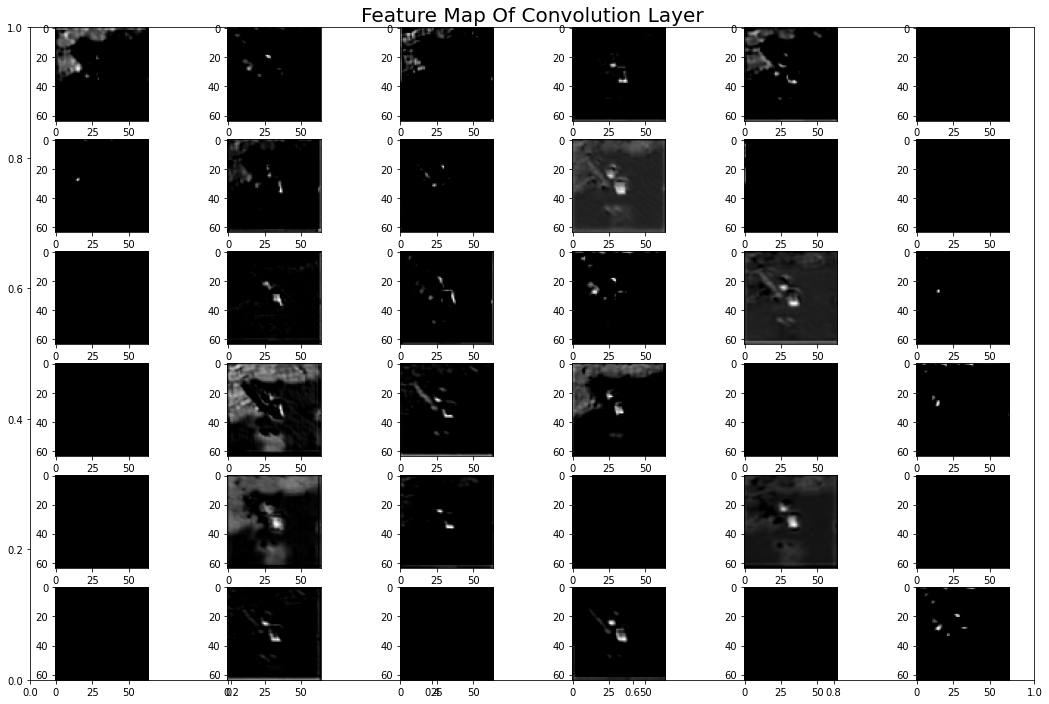

In [23]:
######## CODE SNAPSHAOT INSPIRED BY UNIV.AI LABS #######
layer_outputs = [layer.output for layer in loaded_model.layers[:10]]
activation_model = tf.keras.models.Model(inputs = loaded_model.input, outputs = layer_outputs)
activations = activation_model.predict(np.expand_dims(img1,axis=0))
layer_activation = activations[9]
  
###### PLOTTING THE FEATURE MAPS TO LOOK WHAT OUR MODEL IS LOOKING AT WE CHOOSE AN INTERMEDIATE LAYER TO SEE THE FOCUS OF THE MODEL######
fig = plt.figure(figsize=(18, 12))
plt.title('Feature Map Of Convolution Layer',fontsize=20)
for i in range(36):
    fig.add_subplot(6,6,i+1)
    plt.imshow(layer_activation[0, :, :, i], cmap ='gray')

### FOR DAMAGED BUILDINGS IMAGE
### The above is the  feature maps of the penultimate Convolution's activation to know which part of the image activates our filters or kernels the most. Clearly in our architecture this is a later layer which shall be seeing the image as a whole as compared to the initial layers. It can be seen that feature maps are activated by the trees and the building in the damaged picture. It did take in the account the surrounding water body that is flood like situation preseted by the hurricane in some of the filters

The prediction by model is 0.8999999761581421
[[ True]]


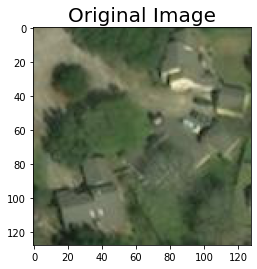

In [24]:
img=Image.open('/kaggle/input/satellite-images-of-hurricane-damage/test_another/no_damage/-95.632386_29.842039.jpeg')
img=np.asarray(img)/255.
plt.imshow(img)
plt.title(f'Original Image',fontsize=20)
print(f'The prediction by model is {np.round(loaded_model.predict(img.reshape(1,128,128,3))[0][0],2)}')
print(loaded_model.predict(img.reshape(1,128,128,3))>=0.5)

### As we take our threshold to be 0.5, and 0 meaning damage and 1 meaning undamaged in our model, the model was  able identify the image correctly, let's look into it why.

(-0.5, 63.5, 63.5, -0.5)

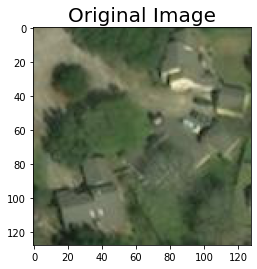

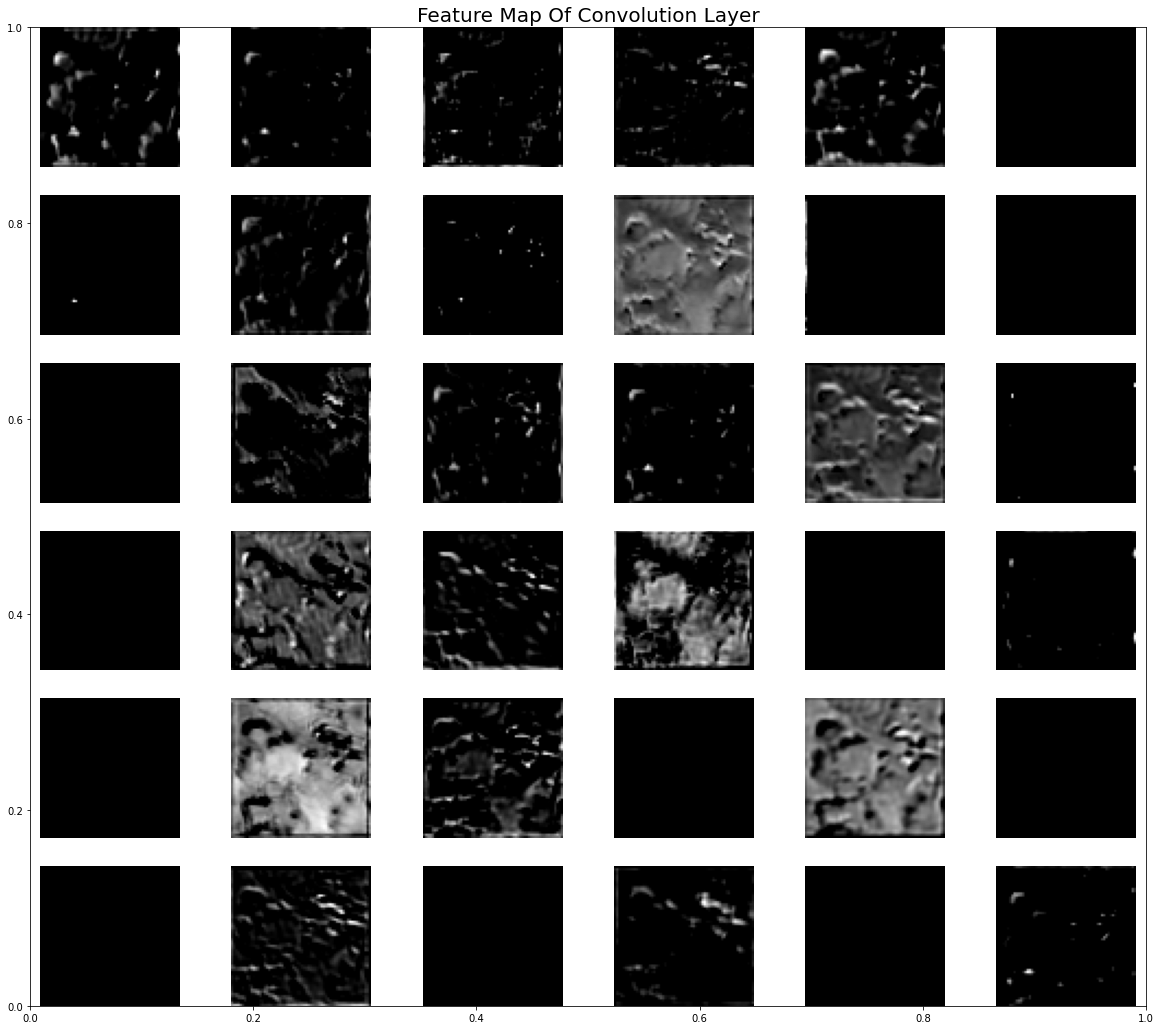

In [26]:
img=Image.open('/kaggle/input/satellite-images-of-hurricane-damage/test_another/no_damage/-95.632386_29.842039.jpeg')
img=np.asarray(img)/255.



plt.imshow(img,cmap='gray')
plt.title(f'Original Image',fontsize=20)




layer_outputs = [layer.output for layer in loaded_model.layers[:10]]
activation_model = tf.keras.models.Model(inputs = loaded_model.input, outputs = layer_outputs)
activations = activation_model.predict(np.expand_dims(img,axis=0))
layer_activation = activations[9]


fig = plt.figure(figsize=(20,18))
plt.title('Feature Map Of Convolution Layer',fontsize=20)
for i in range(36):
    fig.add_subplot(6,6,i+1)
    plt.axis('off')
    plt.imshow(layer_activation[0, :, :, i], cmap ='gray')
    
plt.axis('off')

### FOR UNDAMAGED BUILDING IMAGE

### The above feature map is taken for the same layer but a undamaged surrounding is provided to the actiavtion model . The filters are identifying the input image as a whole in some filters. Even boundries are identified in row 5 column 2. The feature maps seem to be activated much more by trees and the gronud in this case than the buildings in it.

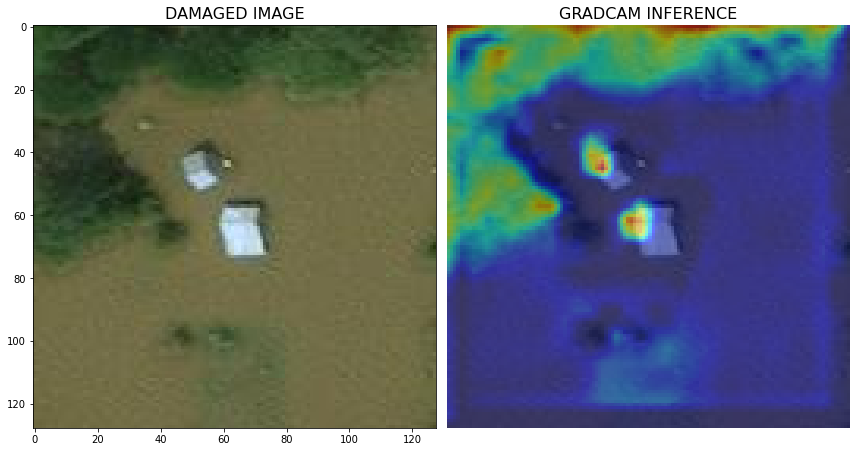

In [28]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import BinaryScore
from matplotlib import cm


# Creating Score 
score = BinaryScore([0])

replace2linear = ReplaceToLinear()


gradcam = GradcamPlusPlus(loaded_model,
                          model_modifier=replace2linear,
                          clone=True)

# Generating the heatmap 
cam = gradcam(score,
              np.asarray([img1]),
              penultimate_layer=-1)
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(12, 10))
heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
ax[1].set_title('GRADCAM INFERENCE', fontsize=16)
ax[1].imshow(img1)
ax[1].imshow(heatmap, cmap='jet', alpha=0.5)
ax[1].axis('off')

ax[0].set_title('DAMAGED IMAGE', fontsize=16)
ax[0].imshow(img1)
ax[1].axis('off')

plt.tight_layout()
plt.show()


### The GradCamPlus heatmap shows that both the surroundings around the building and the greenary is affecting the model's decision making. One assumption can be that by looking at the trees and the pixels just surrounding them( water or the ground) to identify water level.

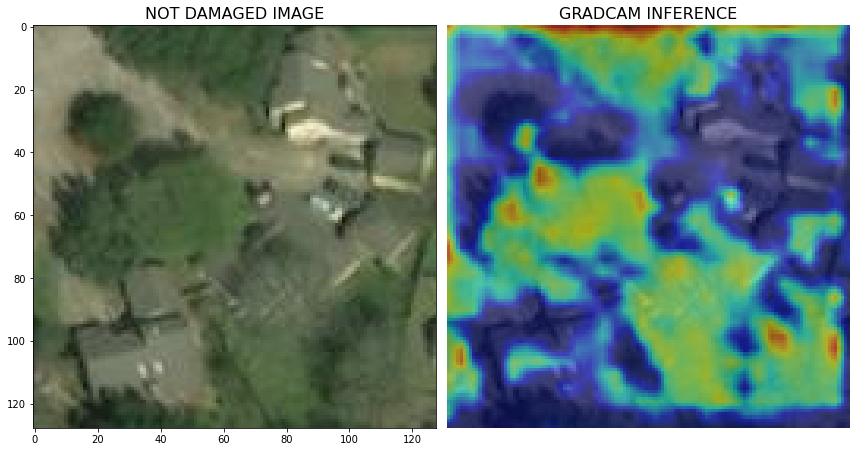

In [29]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

score = BinaryScore([1])


gradcam = GradcamPlusPlus(loaded_model,
                          model_modifier=replace2linear,
                          clone=True)

# Generate heatmap with GradCAM++
cam = gradcam(score,
              np.asarray([img]),
              penultimate_layer=-1)
f, ax = plt.subplots(nrows=1,ncols=2, figsize=(12, 10))
heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
ax[1].set_title('GRADCAM INFERENCE', fontsize=16)
ax[1].imshow(img)
ax[1].imshow(heatmap, cmap='jet', alpha=0.5)
ax[1].axis('off')

ax[0].set_title('NOT DAMAGED IMAGE', fontsize=16)
ax[0].imshow(img)
ax[1].axis('off')

plt.tight_layout()
plt.show()

### In a picture for no damage, grad cam is reciprocating its behaviour, still monitoring the tree and the ground just next to it but also which is around it. 

## The Model trained with 35 epochs 
### We train our model further 10 epochs with a learning rate same as the one used initially and the last 5 epochs for a learning rate of 0.0001. We used the history_basic1 variable to train our model and we saved our weights and model.

#### Once again we load our saved model then we will train on that model, kind of transfer learning XD.

In [ ]:
### ALREADY LOADED ONCE BEFORE

# json_file = open('/kaggle/input/mymodel/model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights('/kaggle/input/mymodel/model.h5')
# print("Loaded model from disk")

In [ ]:
# history_basic1=loaded_model.fit(traingen,validation_data=valgen,epochs=10,steps_per_epoch=40,validation_steps=8)

In [ ]:
loaded_model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

In [ ]:
# history_basic1=loaded_model.fit(traingen,validation_data=valgen,epochs=5,steps_per_epoch=40,validation_steps=8)

#### The loss plots for thhe above are:

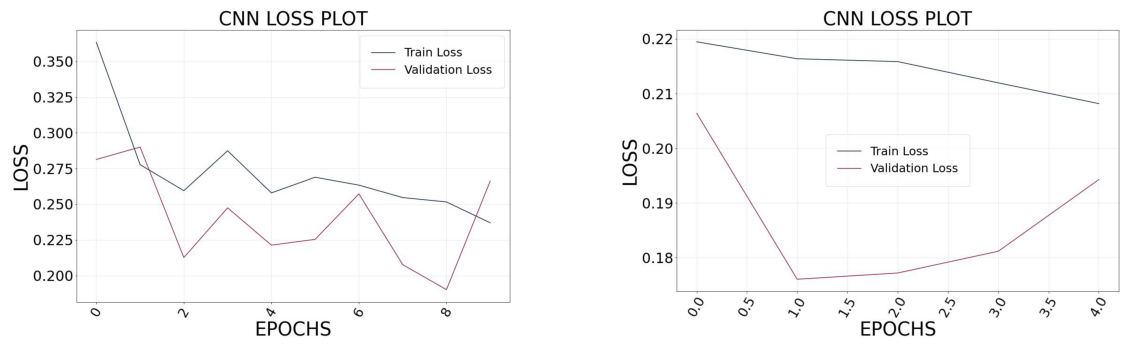

In [30]:
img=Image.open('/kaggle/input/loss-and-accuracy-plots/LOSS1.jpeg')
img1=Image.open('/kaggle/input/loss-and-accuracy-plots/LOSS2.jpeg')
images=[img,img1]
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,15))
for i in range(2):
    ax[i].imshow(images[i])
    ax[i].axis('off')


### ***The one on the left represents the loss plot for the 10 epochs with learning rate 0.001 and the one at the right depicts the last 5 epochs with learning rate 0.0001***

#### The accuracy Plots are shown as below:


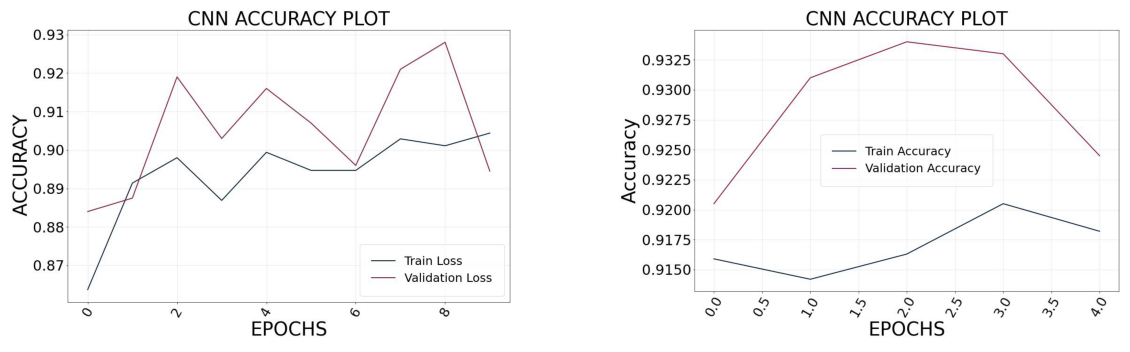

In [31]:
img=Image.open('/kaggle/input/loss-and-accuracy-plots/ACCURACY1.jpeg')
img1=Image.open('/kaggle/input/loss-and-accuracy-plots/ACCURACY2.jpeg')
images=[img,img1]
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,15))
for i in range(2):
    ax[i].imshow(images[i])
    ax[i].axis('off')

### ***The one on the left represents the accuracy plot for the 10 epochs with learning rate 0.001 and the one at the right depicts the last 5 epochs with learning rate 0.0001***

#### We saved our model by the following code:

In [ ]:
##THE CODE USED TO SAVE OUR MODELS ##

# model_json = loaded_model.to_json()
# with open("model1.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# loaded_model.save_weights("model1.h5")
# print("Saved model to disk")

In [ ]:
## Now we load our weights for further inspection

In [32]:
json_file = open('/kaggle/input/mymodel/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model2 = model_from_json(loaded_model_json)
# load weights into new model
loaded_model2.load_weights('/kaggle/input/mymodel1/model1.h5')
print("Loaded model from disk")

Loaded model from disk


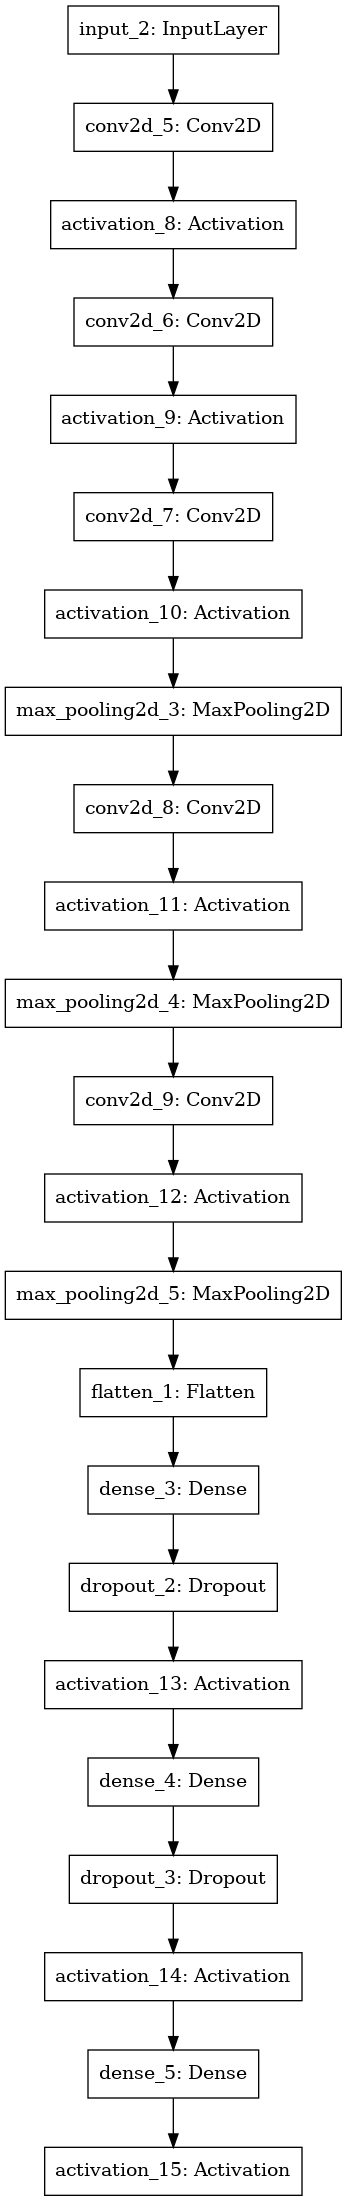

In [33]:
tf.keras.utils.plot_model(loaded_model2)

## 2.1.4.3 INFERENCE FROM BASE MODEL TRAINED FOR 35 EPOCHS
### Once again we do the same investigation of four model to see if we have achieved any improvement

In [34]:
loaded_model2.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

In [35]:
loaded_model2.evaluate(valgen)

8/8 [==============================] - 3s 345ms/step - loss: 0.1943 - accuracy: 0.9245


[0.19427628815174103, 0.9244999885559082]

In [36]:
loaded_model2.evaluate(testgen)

8/8 [==============================] - 3s 376ms/step - loss: 0.2232 - accuracy: 0.9140


[0.22322174906730652, 0.9139999747276306]

In [37]:
loaded_model.evaluate(testgen2)

36/36 [==============================] - 13s 353ms/step - loss: 0.2281 - accuracy: 0.9261


[0.22813870012760162, 0.926111102104187]

### The Accuracy for validation data with equal classes is 0.9245
### The Accuracy for test data with equal classes is 0.9140
### The Accuracy for validation data with equal classes is 0.9261

### We take the same 2 Images that we have taken before.

The prediction by model is 0.029999999329447746
[[False]]


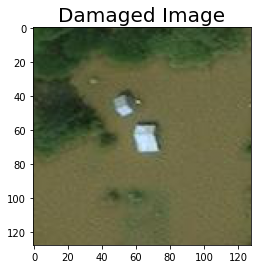

In [38]:
img1=Image.open('/kaggle/input/satellite-images-of-hurricane-damage/test_another/damage/-93.578405_30.779559999999996.jpeg')
img1=np.asarray(img1)/255.


###### PRINTING ORIGINAL IMAGE 
plt.imshow(img1,cmap='gray')
plt.title(f'Damaged Image',fontsize=20)
print(f'The prediction by model is {np.round(loaded_model2.predict(img1.reshape(1,128,128,3))[0][0],2)}')
print(loaded_model2.predict(img1.reshape(1,128,128,3))>=0.5)

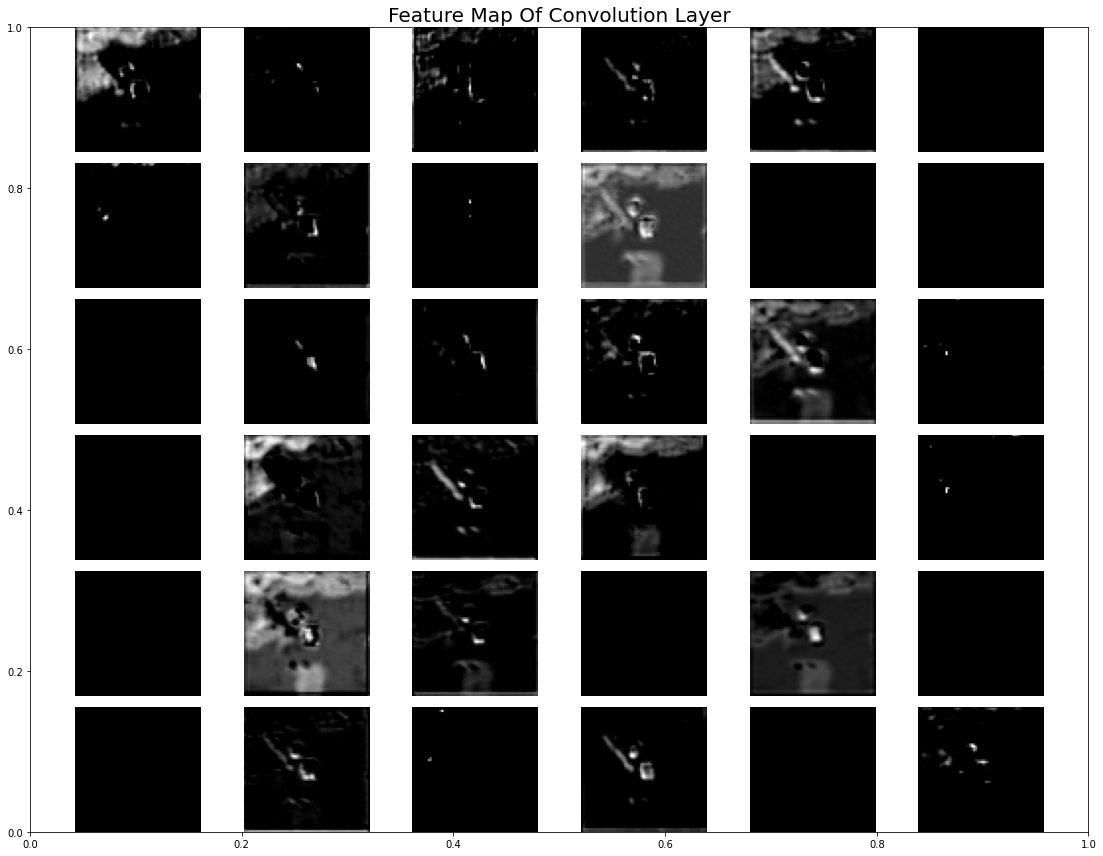

In [39]:

######################### A code Snapshot taken from Univ.AI ##########################
layer_outputs = [layer.output for layer in loaded_model2.layers[:10]]
activation_model = tf.keras.models.Model(inputs = loaded_model2.input, outputs = layer_outputs)
activations = activation_model.predict(np.expand_dims(img1,axis=0))
layer_activation = activations[9]
 ###################################################################################### 

fig = plt.figure(figsize=(15, 12))
plt.title('Feature Map Of Convolution Layer',fontsize=20)
for i in range(36):
    fig.add_subplot(6,6,i+1)
    plt.imshow(layer_activation[0, :, :, i], cmap ='gray')
    plt.axis('off')
    plt.tight_layout()

### After 35 more epochs, you can notice the model learnt to recogonise the buildings or the object inside the image too. The isolated white region in most of the filter maps show that.

The prediction by model is 0.9700000286102295
[[ True]]


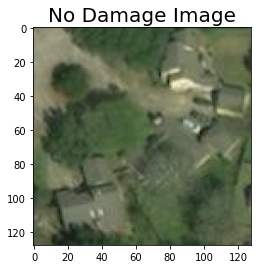

In [40]:
img=Image.open('/kaggle/input/satellite-images-of-hurricane-damage/test_another/no_damage/-95.632386_29.842039.jpeg')
img=np.asarray(img)/255.

###### PRINTING ORIGINAL IMAGE 
plt.imshow(img,cmap='gray')
plt.title(f'No Damage Image',fontsize=20)
print(f'The prediction by model is {np.round(loaded_model2.predict(img.reshape(1,128,128,3))[0][0],2)}')
print(loaded_model2.predict(img.reshape(1,128,128,3))>=0.5)

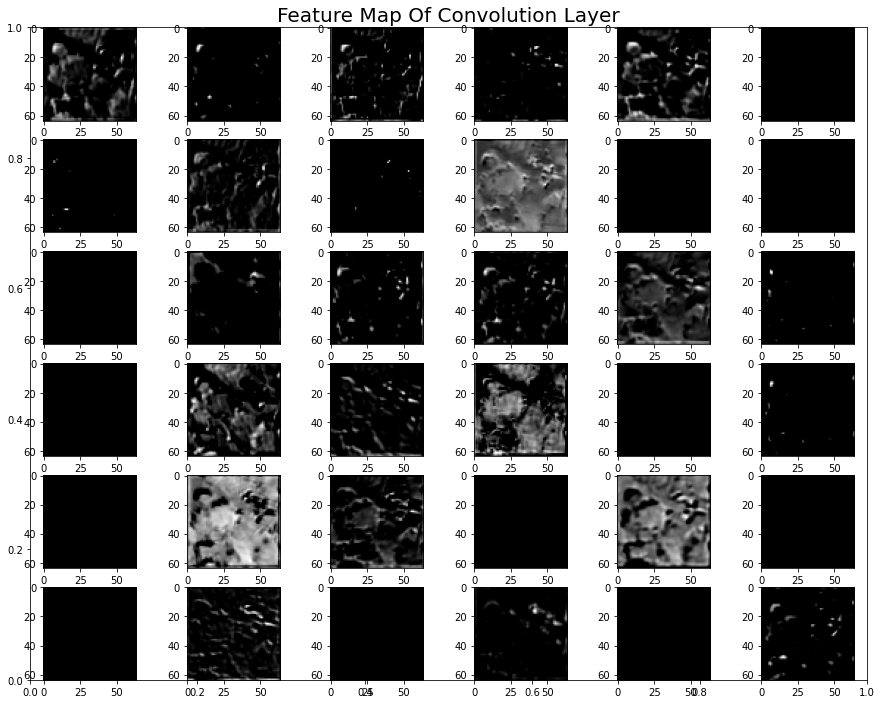

In [41]:
# img=Image.open('/kaggle/input/satellite-images-of-hurricane-damage/train_another/no_damage/-95.0701_29.830762.jpeg')
# img=np.asarray(img)/255.



# plt.imshow(img,cmap='gray')
# plt.title(f'No-DAMAGE Image',fontsize=20)



############### A code Snapshot taken from Univ.AI ######################
layer_outputs = [layer.output for layer in loaded_model2.layers[:10]]
activation_model = tf.keras.models.Model(inputs = loaded_model2.input, outputs = layer_outputs)
activations = activation_model.predict(np.expand_dims(img,axis=0))
layer_activation = activations[9]
############################################################################


fig = plt.figure(figsize=(15,12))
plt.title('Feature Map Of Convolution Layer',fontsize=20)
for i in range(36):
    fig.add_subplot(6,6,i+1)
    plt.imshow(layer_activation[0, :, :, i], cmap ='gray')

### The feature maps not largely different than the one above but are clearer than before.

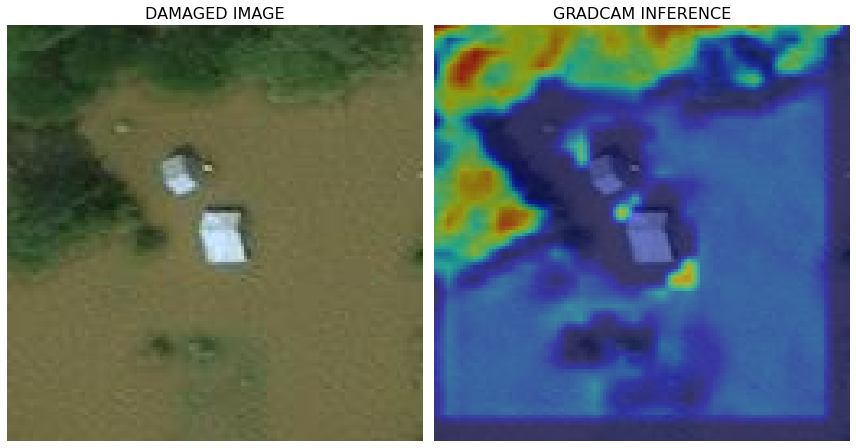

In [91]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import BinaryScore
from matplotlib import cm



score = BinaryScore([0])

replace2linear = ReplaceToLinear()


gradcam = GradcamPlusPlus(loaded_model2,
                          model_modifier=replace2linear,
                          clone=True)

# Generate heatmap with GradCAM++
cam = gradcam(score,
              np.asarray([img1]),
              penultimate_layer=-1)
f, ax = plt.subplots(nrows=1,ncols=2, figsize=(12, 10))
heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
ax[1].set_title('GRADCAM INFERENCE', fontsize=16)
ax[1].imshow(img1)
ax[1].imshow(heatmap, cmap='jet', alpha=0.5)
ax[1].axis('off')

ax[0].set_title('DAMAGED IMAGE', fontsize=16)
ax[0].imshow(img1)
ax[0].axis('off')

plt.tight_layout()
plt.show()


### The inference for the damage using this gradcam heatmap is more clearer than that we had before surroundings are given more weightage while model decision.

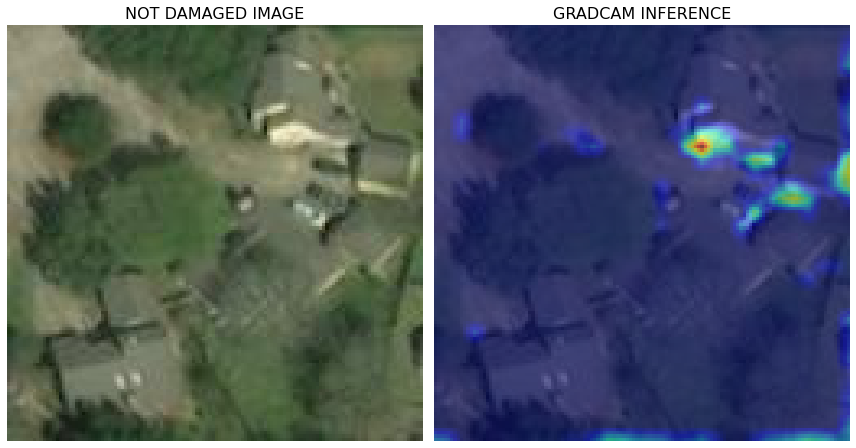

In [90]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()
score = BinaryScore([1])


gradcam = GradcamPlusPlus(loaded_model2,
                          model_modifier=replace2linear,
                          clone=True)

cam = gradcam(score,
              np.asarray([img]),
              penultimate_layer=-1)
f, ax = plt.subplots(nrows=1,ncols=2, figsize=(12, 10))
heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
ax[1].set_title('GRADCAM INFERENCE', fontsize=16)
ax[1].imshow(img)
ax[1].imshow(heatmap, cmap='jet', alpha=0.5)
ax[1].axis('off')

ax[0].set_title('NOT DAMAGED IMAGE', fontsize=16)
ax[0].imshow(img)
ax[0].axis('off')

plt.tight_layout()
plt.show()

### Here the it is showing in the heatmaps are more concentrated on the ground near the  buildings.

## Building Model Using Dilation

In [92]:
#NN From Scracth 

#MOdel1

inputs=tf.keras.Input((128,128,3))
#Initial Layers of 256 Filters 
x=tf.keras.layers.Conv2D(128,5,padding='same',dilation_rate=2)(inputs)
x=tf.keras.layers.Activation(activation='relu')(x)
x=tf.keras.layers.Conv2D(128,5,padding='same')(x)
x=tf.keras.layers.Activation(activation='relu')(x)
x=tf.keras.layers.Conv2D(64,5,padding='same',dilation_rate=2)(x)
x=tf.keras.layers.Activation(activation='relu')(x)



#Decreasing Filters and MAxPool Layers
x=tf.keras.layers.Conv2D(64,3,padding='same',dilation_rate=2)(x)
x=tf.keras.layers.Activation(activation='relu')(x)
x=tf.keras.layers.MaxPool2D(strides=(2,2))(x)
x=tf.keras.layers.Conv2D(8,3,padding='same')(x)
x=tf.keras.layers.Activation(activation='relu')(x)
x=tf.keras.layers.MaxPool2D(strides=(2,2))(x)

#Dense Layers 
x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(400)(x)
x=tf.keras.layers.Dropout(0.3)(x)
x=tf.keras.layers.Activation(activation='relu')(x)
x=tf.keras.layers.Dense(400)(x)
x=tf.keras.layers.Dropout(0.3)(x)
x=tf.keras.layers.Activation(activation='relu')(x)
x=tf.keras.layers.Dense(1)(x)

#Output
out=tf.keras.layers.Activation(activation='sigmoid')(x)

model=tf.keras.Model(inputs,out,name='BaseModel')
model.summary()


Model: "BaseModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 128)     9728      
_________________________________________________________________
activation_16 (Activation)   (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 128, 128, 128)     409728    
_________________________________________________________________
activation_17 (Activation)   (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 128, 128, 64)      204864    
_________________________________________________________________
activation_18 (Activation)   (None, 128, 128, 64)      0 

### You may have noticed that this is a similar architecture to the one used before but with 2-3 times more parameters, this is because we wanted see what impact dilation can have and used it in the initial layers and did not use max-pooling in them and hence the output before flatten is twice than it was before, which contributes to the added parameters

In [ ]:
model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

In [ ]:
# history_basic=model.fit(traingen,validation_data=valgen,epochs=25,steps_per_epoch=40,validation_steps=8)

In [ ]:
plt.rcParams['figure.figsize']=(15,10)

In [ ]:

plt.plot(history_basic.history['loss'],label='Train Loss', color='#051e3e',linewidth=1.5)
plt.plot(history_basic.history['val_loss'],label='Validation Loss', color='#851e3e',linewidth=1.5)
plt.xlabel('EPOCHS',fontsize=40, color='black',)
plt.ylabel('LOSS',fontsize=40, color='black')
plt.xticks(fontsize=28,rotation=60)
plt.yticks(fontsize=30)
plt.ticklabel_format(style='plain', axis='y')
plt.grid(True,color='black',alpha=0.1)
plt.title("DILATED CNN LOSS PLOT",fontsize=40, color='black')
plt.legend(loc=0,borderpad=1,fontsize=25)
plt.tight_layout()
plt.savefig('LOSS.jpeg')

(-0.5, 1079.5, 719.5, -0.5)

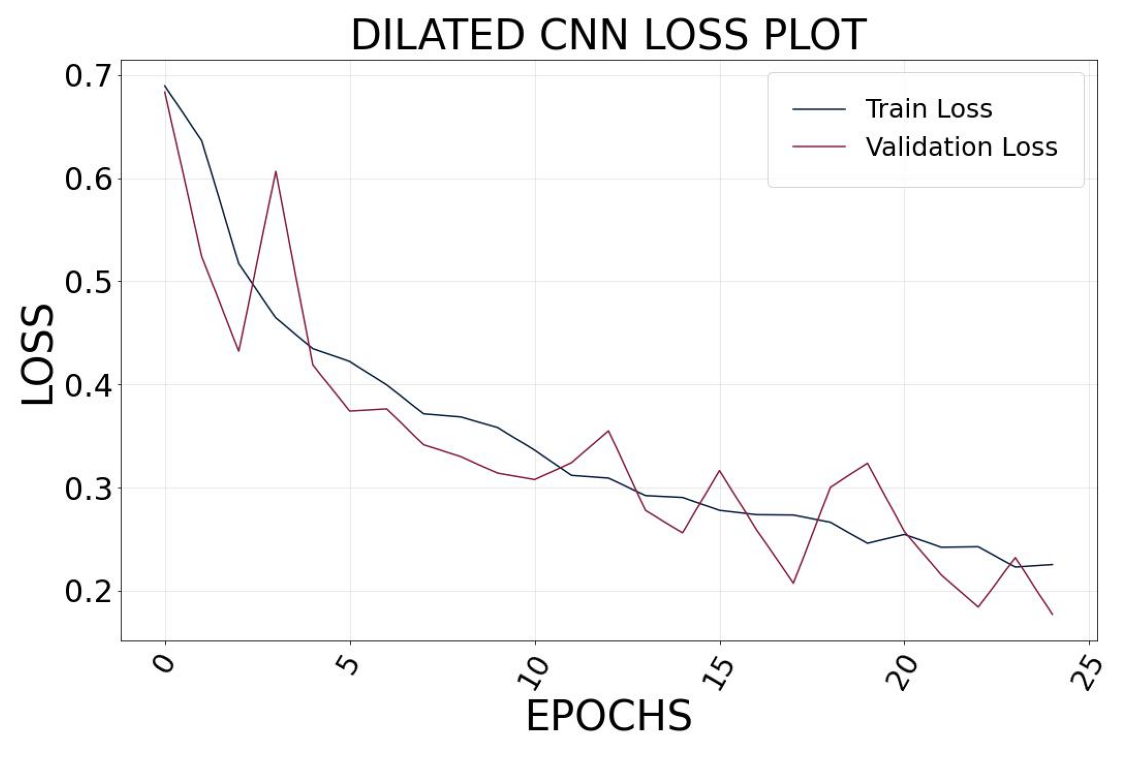

In [3]:
img=Image.open('C:/Users/Aamir/Downloads/loss_dilated.jpeg')
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(20,15))
ax.imshow(img)
ax.axis('off')

In [ ]:
plt.plot(history_basic.history['accuracy'],label='Train', color='#051e3e',linewidth=2)
plt.plot(history_basic.history['val_accuracy'],label='Validation', color='#851e3e',linewidth=2)
plt.xlabel('EPOCHS',fontsize=40, color='black',)
plt.ylabel('Accuracy',fontsize=40, color='black')
plt.xticks(fontsize=28,rotation=60)
plt.yticks(fontsize=30)
plt.ticklabel_format(style='plain', axis='y')
plt.grid(True,color='black',alpha=0.1)
plt.title("DILATED CNN ACCURACY PLOT",fontsize=40, color='black')
plt.legend(loc=0,borderpad=1,fontsize=25)
plt.tight_layout()
plt.savefig('ACCURACY.jpeg')

(-0.5, 1079.5, 719.5, -0.5)

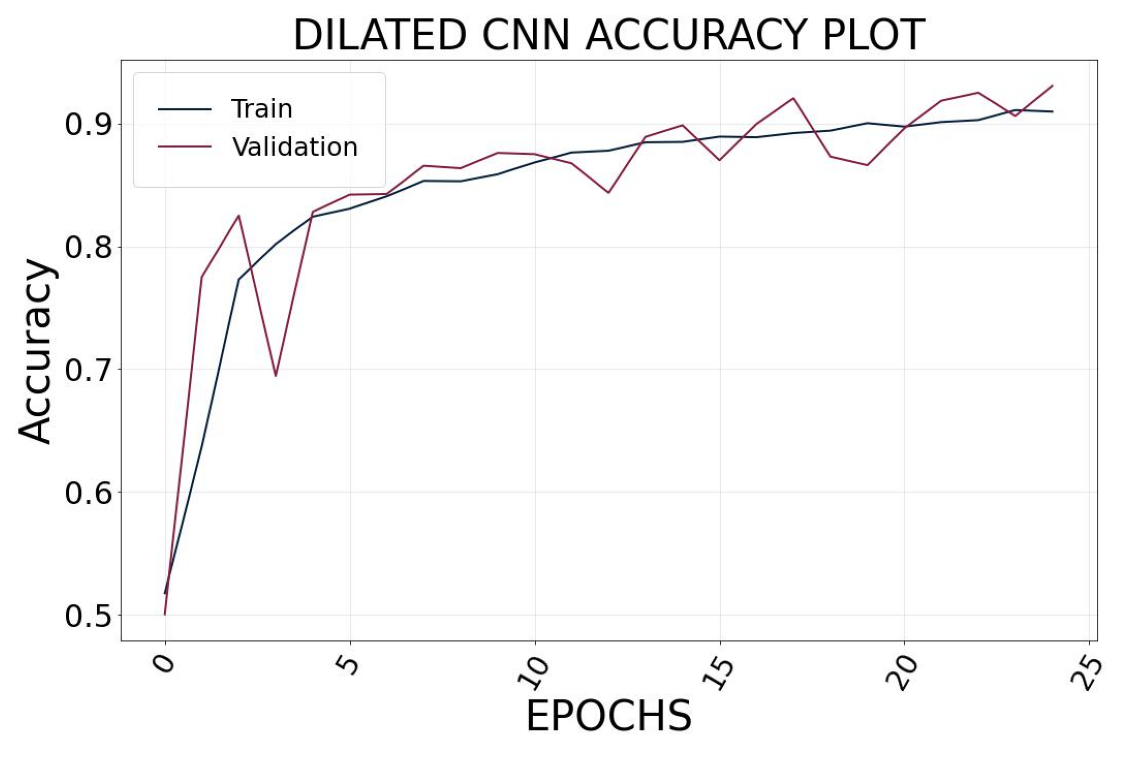

In [4]:
img=Image.open('C:/Users/Aamir/Downloads/accuracy_dilated.jpeg')
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(20,15))
ax.imshow(img)
ax.axis('off')

In [ ]:

### Save Model
# model_json = model.to_json()
# with open("model2.json", "w") as json_file:
#     json_file.write(model_json)
# model.save_weights("model2.h5")
# print("Saved model to disk")


In [47]:
json_file = open('/kaggle/input/dialtedmodel1/model2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
dilated = model_from_json(loaded_model_json)
# load weights into new model
dilated.load_weights('/kaggle/input/dialtedmodel1/model2.h5')
print("Loaded model from disk")

Loaded model from disk


In [48]:
dilated.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

In [49]:
dilated.evaluate(valgen)

8/8 [==============================] - 14s 1s/step - loss: 0.1772 - accuracy: 0.9305


[0.17718736827373505, 0.9304999709129333]

In [50]:
dilated.evaluate(testgen)

8/8 [==============================] - 4s 400ms/step - loss: 0.2015 - accuracy: 0.9165


[0.20154592394828796, 0.9164999723434448]

In [51]:
dilated.evaluate(testgen2)

36/36 [==============================] - 15s 418ms/step - loss: 0.2144 - accuracy: 0.9158


[0.21442893147468567, 0.9157778024673462]

### The Accuracy for validation data with equal classes is 0.9305
### The Accuracy for test data with equal classes is 0.9165
### The Accuracy for validation data with equal classes is 0.9158

The prediction by model is 0.019999999552965164
[[False]]


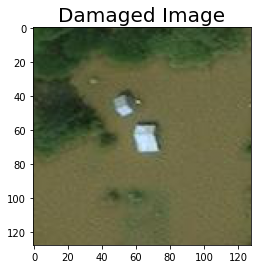

In [57]:
img1=Image.open('/kaggle/input/satellite-images-of-hurricane-damage/test_another/damage/-93.578405_30.779559999999996.jpeg')
img1=np.asarray(img1)/255.

###### PRINTING ORIGINAL IMAGE 
plt.imshow(img1,cmap='gray')
plt.title(f'Damaged Image',fontsize=20)
print(f'The prediction by model is {np.round(dilated.predict(img1.reshape(1,128,128,3))[0][0],2)}')
print(dilated.predict(img1.reshape(1,128,128,3))>=0.5)

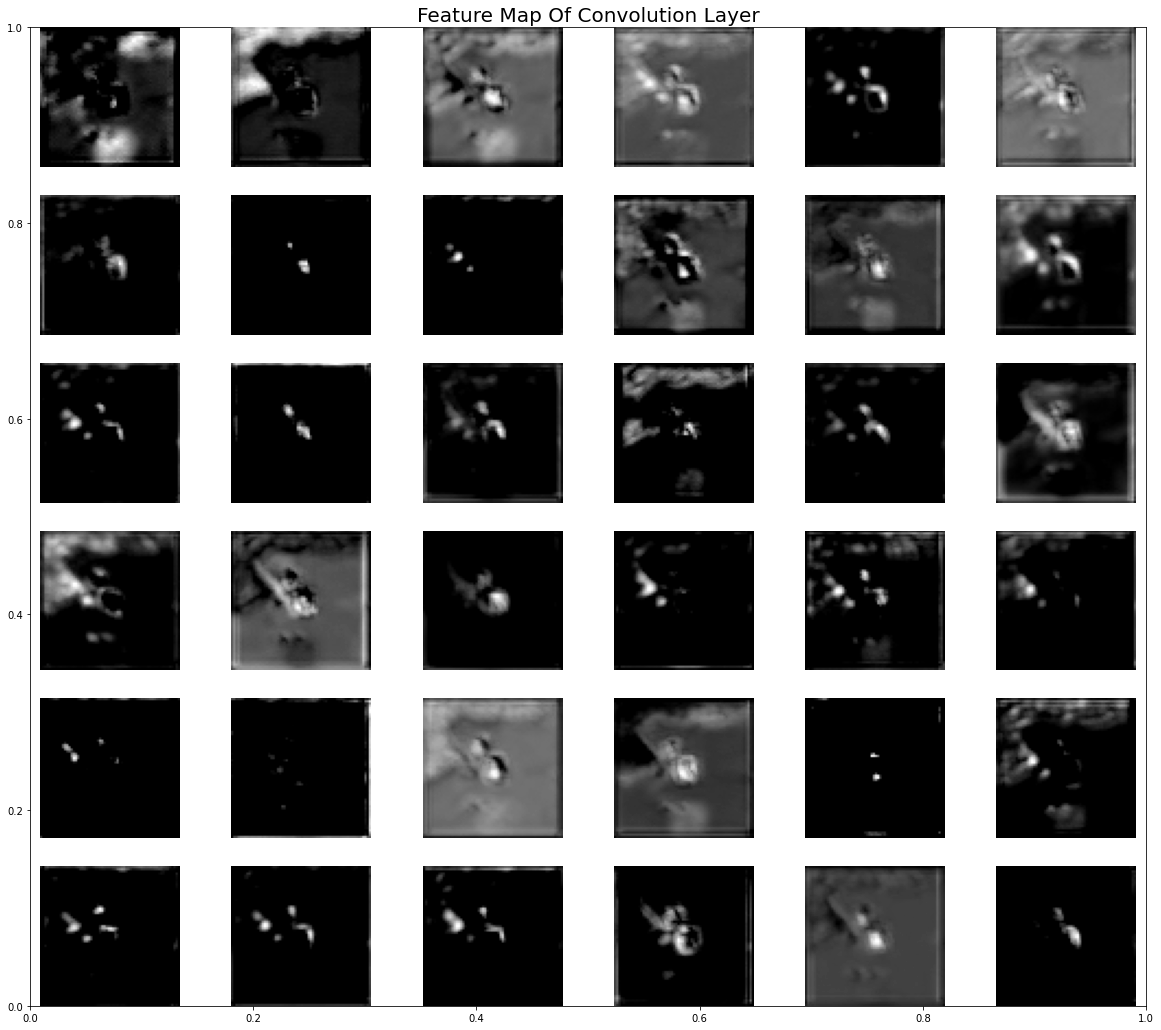

In [53]:
# img1=Image.open('/kaggle/input/satellite-images-of-hurricane-damage/train_another/damage/-93.687415_30.142685999999998.jpeg')
# img1=np.asarray(img1)/255.
# plt.imshow(img1,cmap='gray')
# plt.title(f'Damaged Image',fontsize=20)


######################### A code Snapshot taken from Univ.AI ##########################
layer_outputs = [layer.output for layer in dilated.layers[:10]]
activation_model = tf.keras.models.Model(inputs = dilated.input, outputs = layer_outputs)
activations = activation_model.predict(np.expand_dims(img1,axis=0))
layer_activation = activations[9]
 ###################################################################################### 

fig = plt.figure(figsize=(20, 18))
plt.title('Feature Map Of Convolution Layer',fontsize=20)
for i in range(36):
    fig.add_subplot(6,6,i+1)
    plt.imshow(layer_activation[0, :, :, i], cmap ='gray')
    plt.axis('off')
    

## The feature maps are not redundant now as seen earlier without dilation as we increased the receptive field and are more detailed. The buildings, greenary and the water bodies are now can be seen activating more feature maps

The prediction by model is 0.9800000190734863
[[ True]]


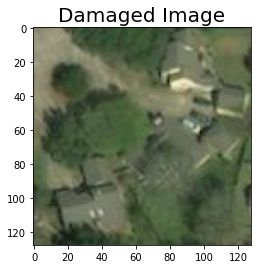

In [54]:
img=Image.open('/kaggle/input/satellite-images-of-hurricane-damage/test_another/no_damage/-95.632386_29.842039.jpeg')
img=np.asarray(img)/255.



plt.imshow(img,cmap='gray')
plt.title(f'No-Damaged Image',fontsize=20)
print(f'The prediction by model is {np.round(dilated.predict(img.reshape(1,128,128,3))[0][0],2)}')
print(dilated.predict(img.reshape(1,128,128,3))>=0.5)


### Pardon for the minor mistake in the title. To clarify, the image shown is of a undamaged class or No-Damage

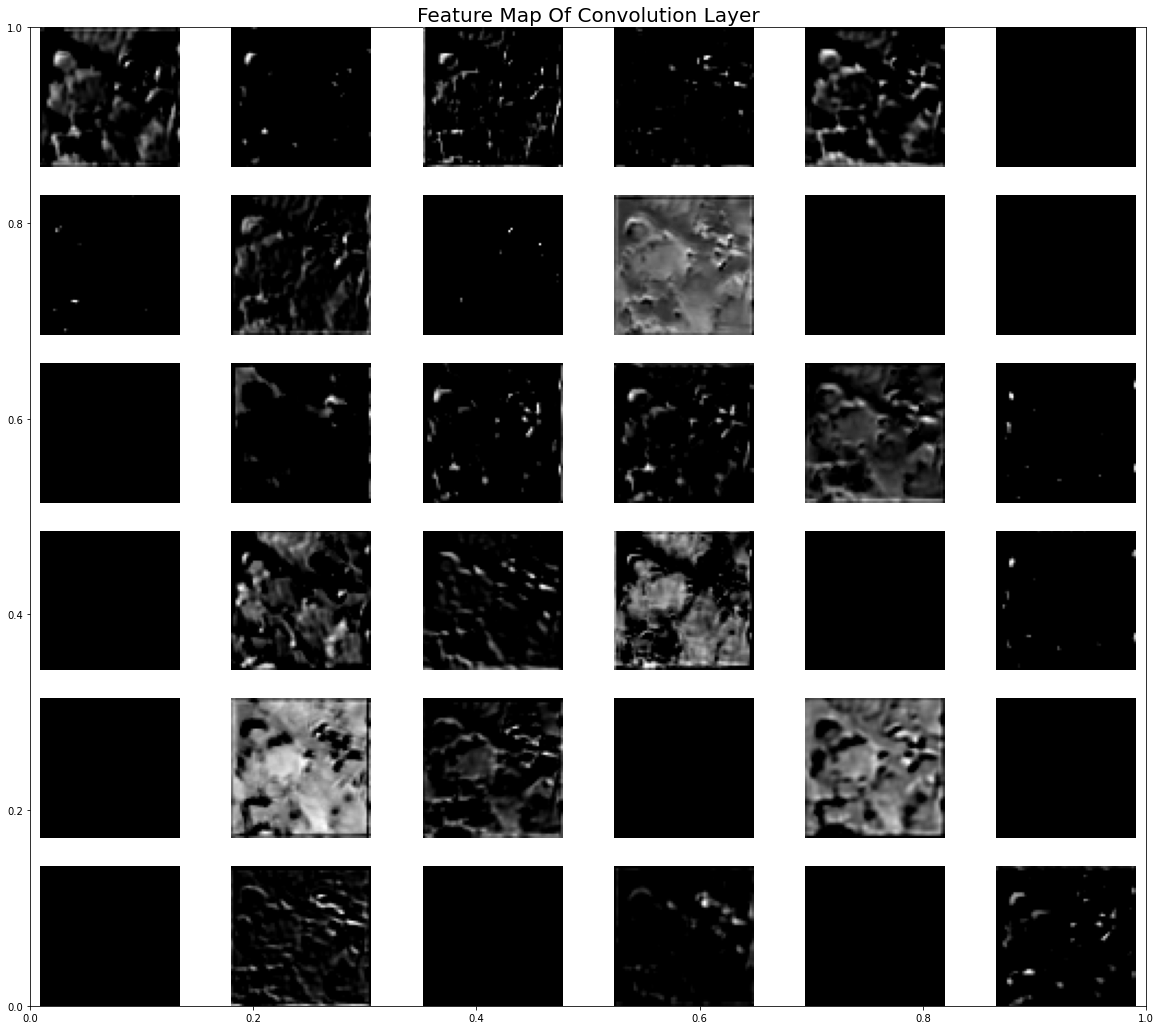

In [55]:



############### A code Snapshot taken from Univ.AI ######################
layer_outputs = [layer.output for layer in loaded_model2.layers[:10]]
activation_model = tf.keras.models.Model(inputs = loaded_model2.input, outputs = layer_outputs)
activations = activation_model.predict(np.expand_dims(img,axis=0))
layer_activation = activations[9]
############################################################################


fig = plt.figure(figsize=(20,18))
plt.title('Feature Map Of Convolution Layer',fontsize=20)
for i in range(36):
    fig.add_subplot(6,6,i+1)
    plt.imshow(layer_activation[0, :, :, i], cmap ='gray')
    plt.axis('off')

## Some feature maps are redundnat in this case as compare to the Damaged image. Some intresting foamy patterns can also be observed but is largely the same as seen with the model trianed for 35 epochs without dilation.

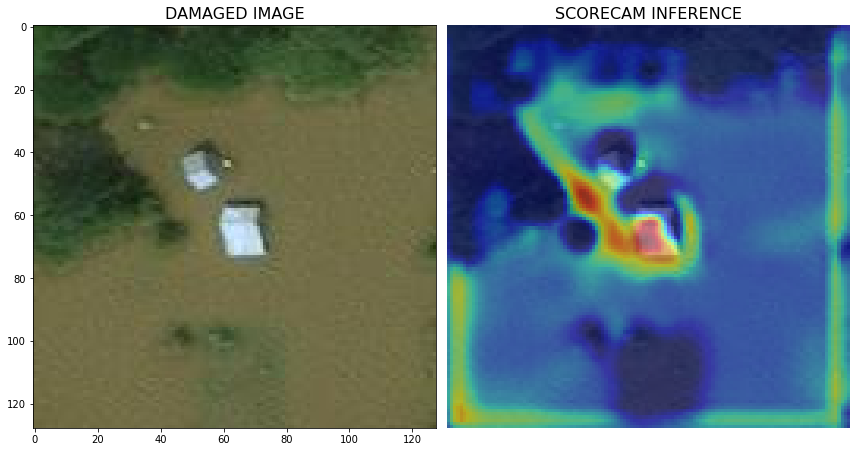

In [84]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.utils import num_of_gpus
from tf_keras_vis.utils.scores import BinaryScore
from matplotlib import cm


score = BinaryScore([0])

replace2linear = ReplaceToLinear()


scorecam = Scorecam(dilated,model_modifier=replace2linear)
cam = scorecam(score, np.asarray([img1]), penultimate_layer=-1)

# gradcam = GradcamPlusPlus(dilated,model_modifier=replace2linear,clone=True)

# cam = gradcam(score,np.asarray([img]),penultimate_layer=-1)


f, ax = plt.subplots(nrows=1,ncols=2, figsize=(12, 10))
heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
ax[1].set_title('SCORECAM INFERENCE', fontsize=16)
ax[1].imshow(img1)
ax[1].imshow(heatmap, cmap='jet', alpha=0.5)
ax[1].axis('off')

ax[0].set_title('DAMAGED IMAGE', fontsize=16)
ax[0].imshow(img1)
ax[1].axis('off')

plt.tight_layout()
plt.show()


## Now this gives more context, Clearly Scorecam gives a better vision on what the results must be based on. The buildings and its surroundings are very are supposed to be very dominant.

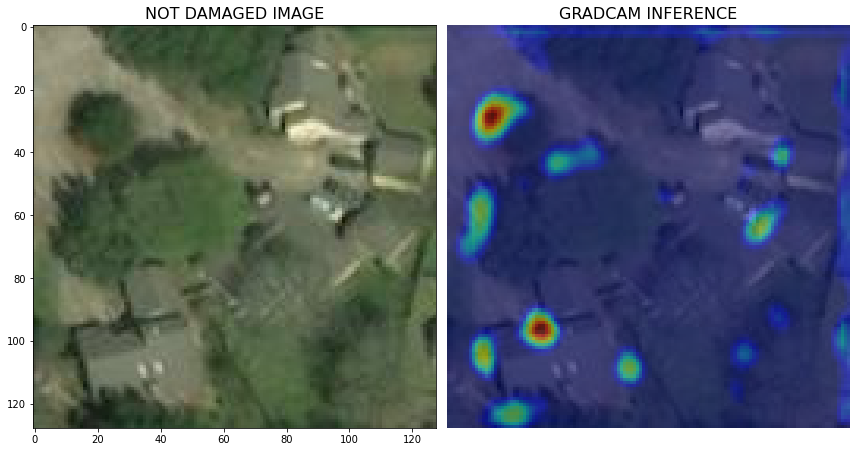

In [87]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

score = BinaryScore([1])
gradcam = GradcamPlusPlus(dilated,
                          model_modifier=replace2linear,
                          clone=True)

cam = gradcam(score,
              np.asarray([img]),
              penultimate_layer=-1)
f, ax = plt.subplots(nrows=1,ncols=2, figsize=(12, 10))
heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
ax[1].set_title('GRADCAM INFERENCE', fontsize=16)
ax[1].imshow(img)
ax[1].imshow(heatmap, cmap='jet', alpha=0.5)
ax[1].axis('off')

ax[0].set_title('NOT DAMAGED IMAGE', fontsize=16)
ax[0].imshow(img)
ax[1].axis('off')

plt.tight_layout()
plt.show()

## Life is difficult sometimes as is ecxtracting some valuable inference from this gradcam+ heatmap but as we say never give up and we won't. One noticable thing here is that the heat is more around the buildings and the trees rather than open field.

# Confusion Matrix Generation

## We create a confusion matrix to know how many false positives( Images in real are damaged but are considered to be No-Damage) and false negatives ( Images containing no-damage buildings but are considered to be dmaged)

In [62]:
valgen1=datagen2.flow_from_directory('/kaggle/input/satellite-images-of-hurricane-damage/test',target_size=(128,128),class_mode='binary',batch_size=256,shuffle=False)
y_true=valgen1.classes

Found 2000 images belonging to 2 classes.


In [63]:
preds=dilated.predict(valgen1)

In [64]:
y_preds=[]
for i in preds:
    if i>=0.5:
        y_preds.append(1)
    else:
        y_preds.append(0)

### Function to extract true positives, true negatives, fasle positives and false negatives, a fairly straight forward function.

In [65]:
def conf(true,predict):
    tp=0
    tn=0
    fp=0
    fn=0
    for i in range(len(true)):
        if(true[i]==predict[i]):
            if true[i]==1:
                tp+=1
            else:
                tn+=1
        else:
            if predict[i]==1:
                fp+=1
            else:
                fn+=1
    return(tp,fp,fn,tn)

In [66]:
conf_out=conf(y_true,y_preds)

In [67]:
cm=np.array(conf_out).reshape((2,2,1))

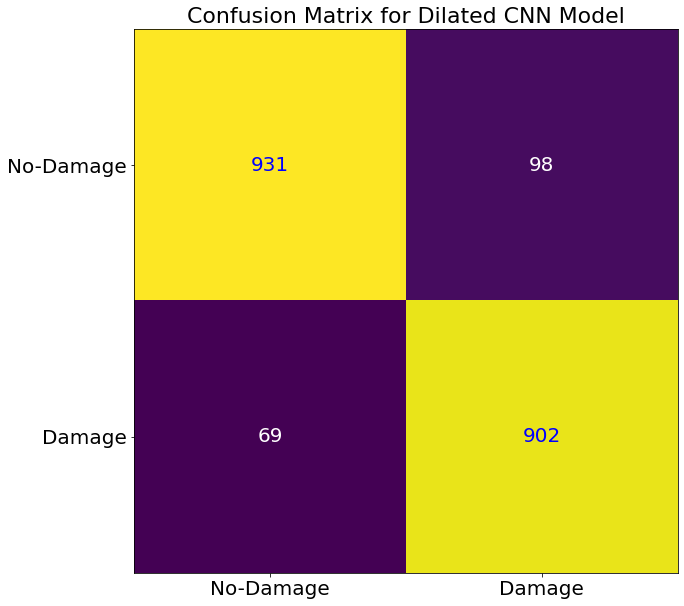

In [68]:
plt.rcParams['figure.figsize']=(15,10)
plt.imshow(cm)
y=['No-Damage','Damage']
x=['No-Damage','Damage']
plt.xticks(range(2),labels=x,fontsize=20)
plt.yticks(range(2),labels=y,fontsize=20)
t=0
for i in range(2):
    for j in range(2):
        if(((i==0) and (j==1)) or (((i==1) and (j==0)))):
            text = plt.text(j,i,conf_out[t],ha="center",va="center",color="w",fontsize=20)
        else:
            text = plt.text(j,i,conf_out[t],ha="center",va="center", color="b",fontsize=20)
        t+=1
plt.title('Confusion Matrix for Dilated CNN Model',fontsize=22)
plt.savefig('dilated_confusion.jpeg',dpi=300)

### As you can notice there are 69 false positive images and 98 flase negatives are present in our models predictions.  

# Loss Heatmaps Generation by Providing Clipped Images 

### We create new images by clipping chunks of it and replacing it by black blocks. We use a clipping size of 32*32 across all the channel.

### We take the loss while evaluating model for the original image as the base loss.
### Similarly we take loss for all the clipped images and oberve how much a portion of image increases or decreases the loss.
### On the above architecture we create our heatmap.

In [69]:
def clip(img):
    #Pointers for number of rows
    y_1=0
    y_2=32
    image_list=[]
    bbox=[]
    img_arr=np.asarray(img)*(1./255)
    #Clipper
    clipper=np.zeros(shape=(32,32,3))
    while(y_2<128):
        #Pointers for number of columns
        i=0
        j=32
        while(j<128):
            new_img=img_arr.copy()
            new_img[y_1:y_2,i:j,:]=clipper
            image_list.append(new_img)
            bbox.append((y_1,y_2,i,j))
            i+=16
            j+=16
        y_1+=16
        y_2+=16
    return (image_list,bbox)
        
## We also return the box coordinates which will help us in generating heatmaps

In [74]:
img_test=Image.open('/kaggle/input/satellite-images-of-hurricane-damage/test_another/damage/-93.578405_30.779559999999996.jpeg')

Text(0.5, 1.0, 'Damaged Image Original')

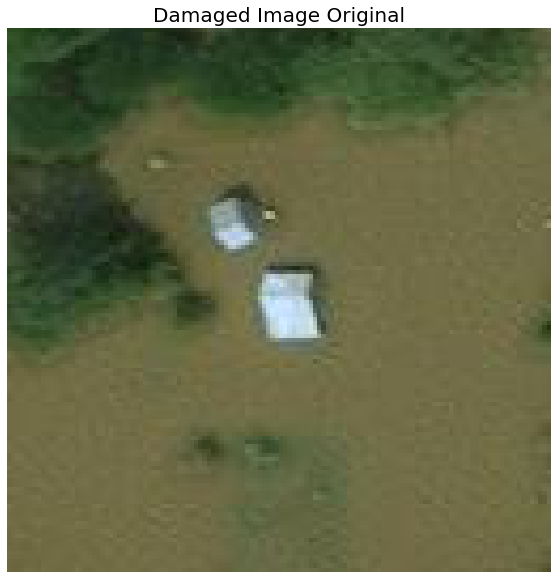

In [71]:
plt.imshow(img_test)
plt.axis('off')
plt.title('Damaged Image Original',fontsize=20)

In [72]:
### Clipped IMages are Extracted ###
test_list=clip(img_test)

(-0.5, 127.5, 127.5, -0.5)

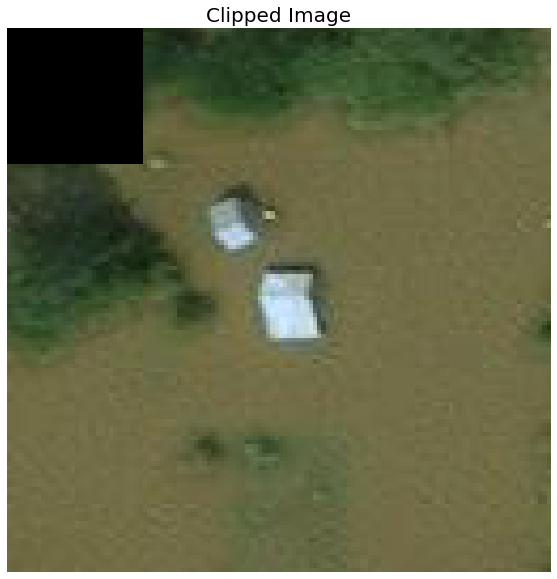

In [73]:
#### A RANDOM CLIPPED IMAGE ####
plt.imshow(test_list[0][np.random.randint(0,len(test_list))])
plt.title('Clipped Image',fontsize=20)
plt.axis('off')

In [75]:
#### Calculating Loss for the original image #### 
img_test=np.asarray(img_test).reshape((1,128,128,3))*(1./255)
y=np.asarray([[0]])
loss=dilated.evaluate(x=img_test,y=y)
base_loss=loss[0]



1/1 [==============================] - 0s 176ms/step - loss: 0.0184 - accuracy: 1.0000


In [76]:

#### LOSS FOR EVERY IMAGE AND APPENDING TEH DIFFERENCE FORM BASE LOSS #####
clip_images=test_list[0]
out_loss=[]
for i in range(len(clip_images)):
    clip_image=clip_images[i].reshape((1,128,128,3))
    clip_out=np.asarray([[0]])
    a=dilated.evaluate(clip_image,clip_out)
    out_loss.append(base_loss-a[0])

1/1 [==============================] - 0s 22ms/step - loss: 0.0138 - accuracy: 1.0000


In [77]:
print(f'The base loss of the whole image is {np.round(base_loss,3)}')

The base loss of the whole image is 0.018


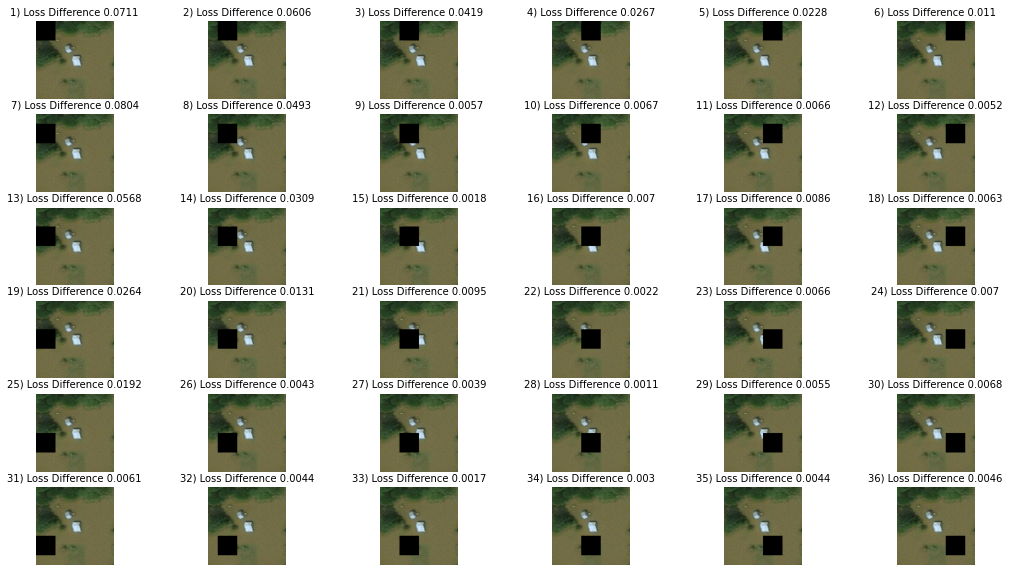

In [78]:
fig,ax=plt.subplots(6,6,figsize=(18,10))
t=0
for i in range(6):
    for j in range(6):
        ax[i,j].imshow(clip_images[t])
        ax[i,j].set_title(f'{t+1}) Loss Difference {np.round(abs(out_loss[t]),4)}',fontsize=10)
        ax[i,j].axis('off')
        t+=1

## Image 7 produces the most difference in loss as it increases far more considerably than clipping any other part of the image.

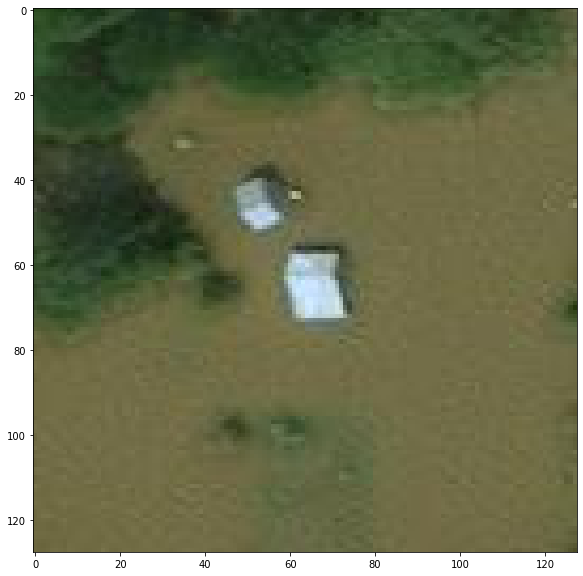

In [79]:
img_test=Image.open('/kaggle/input/satellite-images-of-hurricane-damage/test_another/damage/-93.578405_30.779559999999996.jpeg')
plt.imshow(img_test)

## GENERATING THE HEATMAP

In [80]:
new=np.asarray(img_test)
vacant=np.zeros((128,128,3))
vacant[:,:,:3]=new
vacant=vacant*(1./255)
zipped=zip(np.abs(out_loss),test_list[1])
zipped_sorted=sorted(zipped,key=lambda x:-x[0])

### K is the base color for our heatmap and we exploit the red channel to create a heatmap

In [81]:
k=2
for i,j in (zipped_sorted):
    x,y,t,u=j
    vacant[x:y,t:u,0]+=k
    k=k-0.1

([], [])

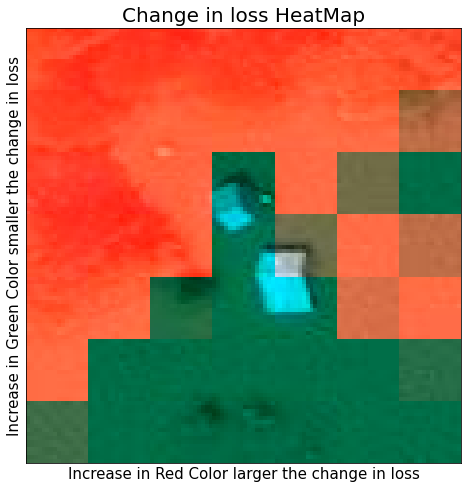

In [82]:
fig,ax=plt.subplots(figsize=(8,8))
plt.imshow(vacant[:112,:112,:])
plt.title('Change in loss HeatMap', fontsize=20)
plt.xlabel('Increase in Red Color larger the change in loss',fontsize=15)
plt.ylabel('Increase in Green Color smaller the change in loss',fontsize=15)
plt.xticks([])
plt.yticks([])

## ---------------------------------------------------------------------------------------------------------------------------------

# 2.2 PART - B : TRANSFER LEARNING

In [1]:
#Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import sys
import pandas as pd
import tensorflow as tf
from glob import glob
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from glob import glob
from IPython.display import clear_output
# Importing NasNetMobile
from keras.applications.nasnet import NASNetMobile
from tensorflow.keras.applications.nasnet import preprocess_input
from tensorflow.keras.models import Model
from keras.models import load_model

!pip3 -qq install tf_keras_vis 
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.scorecam import Scorecam
from tf_keras_vis.utils.scores import BinaryScore
from tf_keras_vis.utils.scores import CategoricalScore
from matplotlib import cm

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix 

#For downloading data from Drive
! conda install -y gdown
clear_output()

In [2]:
# Using the code from a previous homework to get feature maps
def get_feature_maps(model, layer_id, input_image):
    model_ = Model(inputs=[model.input], outputs=[model.layers[layer_id].output])
    return model_.predict(np.expand_dims(input_image, axis=0))[0,:,:,:].transpose((2,0,1))

In [3]:
#Downloading the data and removing the zip file
if  os.path.isdir('/content/Post-hurricane.zip/')==True:
    !unzip Post-hurricane.zip  -d /content/
    os.remove('Post-hurricane.zip')
else:
    # os.makedirs('gdrive/My Drive/Hurricane')
    !gdown --id 1EH3p84xKMs_2m4ISSR7aHOQz61yxIv8L
    !unzip Post-hurricane.zip  -d /content/
    os.remove('Post-hurricane.zip')
clear_output()

In [4]:
# Moving the contents of the zip file into a single directory and renaming the them for easy access 

if os.path.isdir('/content/Hurricane/')== False:
  os.makedirs('/content/Hurricane/', exist_ok=True)
#moving the directories
  shutil.move('/content/train_another', '/content/Hurricane/')
  shutil.move('/content/test_another', '/content/Hurricane/')
  shutil.move('/content/validation_another', '/content/Hurricane/')
  shutil.move('/content/test', '/content/Hurricane/')
#renaming the directories
  os.rename('/content/Hurricane/train_another', '/content/Hurricane/train')
  os.rename('/content/Hurricane/test_another', '/content/Hurricane/test_another')
  os.rename('/content/Hurricane/validation_another', '/content/Hurricane/validation')
  os.rename('/content/Hurricane/test', '/content/Hurricane/test')

In [5]:
# Using the Data generator to provide the images in batches along with processing them on the go
#Also setting shuffle to false for easy access later on - it should have no effect on the training itself
#We are also using the preprocess_input of the NasNetMobile here

aug=ImageDataGenerator(preprocessing_function=preprocess_input)

train = aug.flow_from_directory('/content/Hurricane/train', target_size=(224, 224),class_mode='binary',shuffle='False')
val = aug.flow_from_directory('/content/Hurricane/validation/', target_size=(224, 224),class_mode='binary',shuffle='False')
test_another = aug.flow_from_directory('/content/Hurricane/test_another/', target_size=(224, 224),class_mode='binary',shuffle='False')
test=aug.flow_from_directory('/content/Hurricane/test',target_size=(224, 224),class_mode='binary',shuffle='False')

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [6]:
#getting the already saved best model and its history
if os.path.exists('Best_NasNet_model.h5')==False:
    !gdown --id 1JD7sjKpSAac8EeIg4rAyTBIZ68GKvSNa #model
    !gdown --id 1CNEGnRu2Cp6z_bClqEhDpq1Kuq0SDujN  #history
clear_output()

In [7]:
# If the best model file isn't available, try running the NasNetMobile from start
if os.path.exists('Best_NasNet_model.h5')==False:
    base_model=NASNetMobile(include_top=False,weights='imagenet') #initializing imagenet weights and removing the Dense layers
    for layer in base_model.layers[:500]:  # Freezing first 500 layers as they would be better at getting the basic shapes
        layer.trainable=False   #Training the rest of the layers to specifically identify builings among the floods and normal terrain
clear_output()

In [8]:
# Adding some layers to make a sense of the patterns picked up by the Convolution layers
if os.path.exists('Best_NasNet_model.h5')==False:
    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(1024,activation='relu')(x)
    x=Dense(512,activation='relu')(x)
    out=Dense(1,activation='sigmoid')(x) 
    # Adding checkpoints to get the best model and saving its history for future reference
    # Not using EarlyStopping as it stops the model from moving to a better minima (could have used morer patience, but ModelCheckpoint does a good job)
#   es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3) 
    mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    hist = tf.keras.callbacks.CSVLogger('log.csv', separator=",", append=False) #Saving the History

    model_t=Model(inputs=base_model.input,outputs=out)
    model_t.summary()
    model_t.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
#Fitting the model with validation data, 150 epochs(we get good results in under 100) and callbacks
if os.path.exists('Best_NasNet_model.h5')==False:  
    step_size_train=train.n//train.batch_size
    step_size_validation=val.n//val.batch_size
    history_t=model_t.fit(train,steps_per_epoch=step_size_train,validation_data=val,validation_steps=step_size_validation,epochs=150,callbacks=[mc,hist])

In [10]:
#Evaluating the performance on the test and test_another
if os.path.exists('Best_NasNet_model.h5')==False:  
    print(1)
    eval_test_main=model_t.evaluate(test)
    eval_test_another_main=model_t.evaluate(test_another)
    print('Loss on unbiased data =',eval_test_main[0],'Accuracy of unbiased data=',eval_test_main[1])
    print('Loss on biased data =',eval_test_another_main[0],'Accuracy of biased data=',eval_test_another_main[1])

In [11]:
if os.path.exists('Best_NasNet_model.h5')==False: 
    fig,(ax,ay)=plt.subplots(1,2,figsize=(17,10))
    ax.plot(history_t.history['accuracy'])
    ax.plot(history_t.history['val_accuracy'])
    ax.set_title('model accuracy')
    ax.set_ylabel('accuracy')
    ax.set_xlabel('epoch')
    ax.legend(['train', 'test'], loc='upper left')
    ax.ylim(0,1)

    ay.plot(history_t.history['loss'])
    ay.plot(history_t.history['val_loss'])
    ay.set_title('model loss')
    ay.set_ylabel('loss')
    ay.set_xlabel('epoch')
    ay.legend(['train', 'test'], loc='upper left')
    plt.savefig('accuracy_loss.jpeg')
    plt.show()

# Loading the saved model 

In [12]:
better_model = load_model('Best_NasNet_model.h5')
hist_csv=pd.read_csv('log.csv')
# And evaluating its performance
eval_test=better_model.evaluate(test)
eval_test_another=better_model.evaluate(test_another)
# clear_output()

2021-12-16 02:36:38.225160: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-16 02:36:38.331653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-16 02:36:38.332404: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-16 02:36:38.333722: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

282/282 [==============================] - 20s 69ms/step - loss: 0.3047 - accuracy: 0.9789


In [13]:
print('Loss on unbiased data =',np.round(eval_test[0],3),'\nAccuracy of unbiased data=',np.round(eval_test[1],3))
print('\nLoss on biased data =',np.round(eval_test_another[0],3),'\nAccuracy of biased data=',np.round(eval_test_another[1],3))

Loss on unbiased data = 0.121 
Accuracy of unbiased data= 0.99

Loss on biased data = 0.305 
Accuracy of biased data= 0.979


In [14]:
#To see the downloaded images
def clear_image(image_index):
    temp_1=test_another.filenames[image_index]
    img_path = glob('/content/Hurricane/test_another/')[0]+temp_1
    img = image.load_img(img_path,target_size=(224,224,3))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.
    return img_tensor[0]

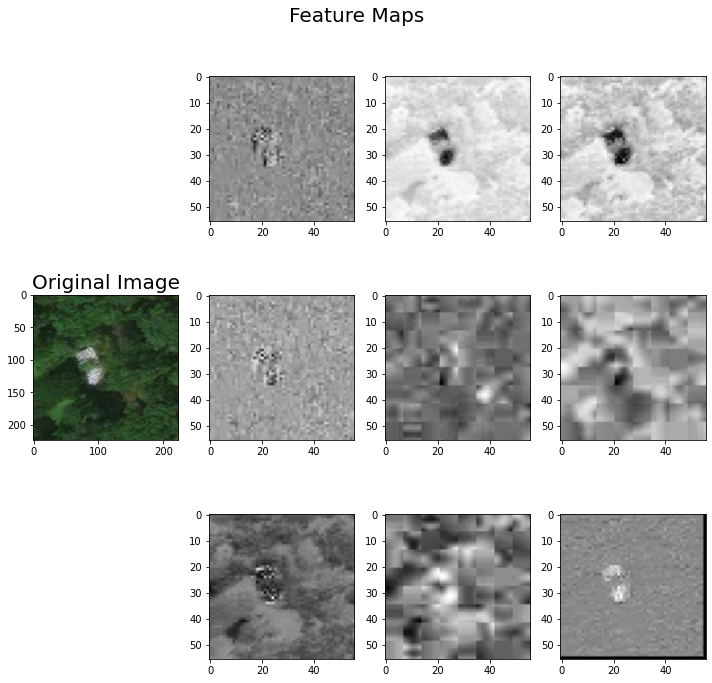

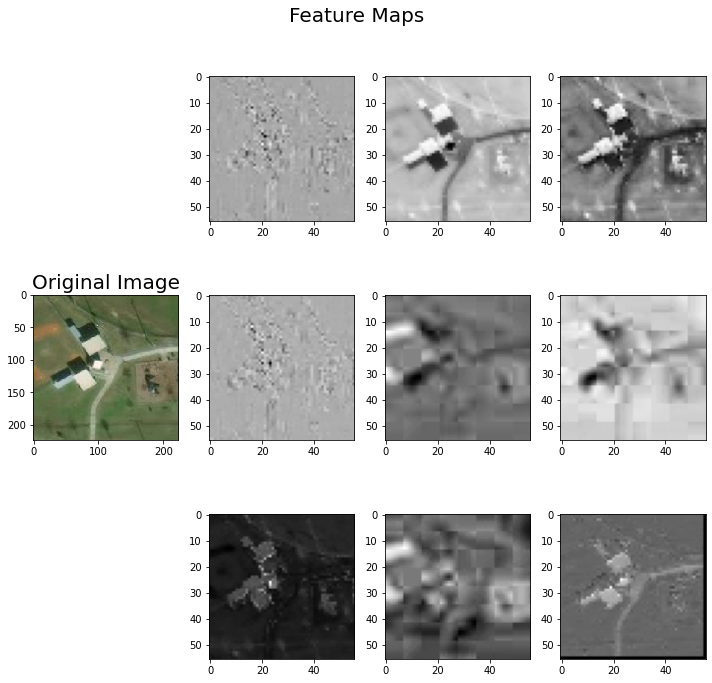

In [15]:
#plotting the Feature maps 
for j in [clear_image(25),clear_image(8001)]:
    fig,ax=plt.subplots(3,4,figsize=(10,10))
    for i, ax in enumerate(ax.ravel()):
      if i==0 or i==8:
        fig.delaxes(ax)
      if i==4:
        ax.imshow(j)
        ax.set_title('Original Image',fontsize=20)
      else:
        ax.imshow(get_feature_maps(better_model, 60, j)[i],cmap='gray')
      fig.suptitle('Feature Maps',fontsize=20)
      plt.tight_layout()
# plt.savefig('feature_map.jpeg')

In [16]:
# We are modifying the last layer activation of our model to give us better results (as sigmoid/softmax give the result in probabilities, the results won't be good)
def model_modifier_function(model):
    model.layers[-1].activation = tf.keras.activations.linear

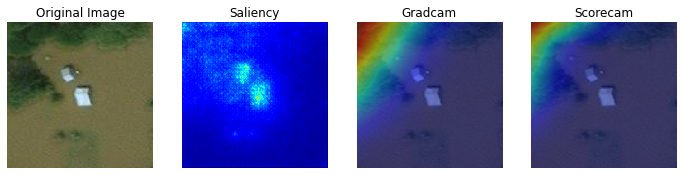

<Figure size 432x288 with 0 Axes>

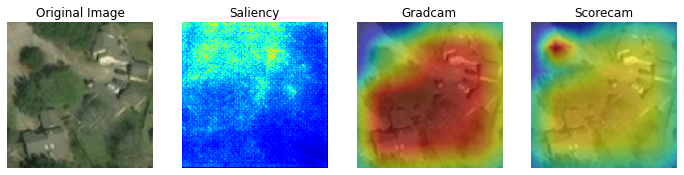

<Figure size 432x288 with 0 Axes>

In [17]:
# Creating Saliency,Gradcam and Scorecam
saliency = Saliency(better_model,model_modifier=model_modifier_function,clone=True)
gradcam = Gradcam(better_model,model_modifier=model_modifier_function,clone=True)
scorecam = Scorecam(better_model, model_modifier=model_modifier_function)
for i in [21,8512]:
    
    img=clear_image(i)
    X= np.asarray([img])
    if i==21:
        score = BinaryScore([0])
    if i==8512:
        score = BinaryScore([1])


    #Saliency map
    saliency_map = saliency(score,X,smooth_samples=20,smooth_noise=0.20)


    #Gradcam
    cam = gradcam(score,X,penultimate_layer=-1)
      
    #Scorecam
    scam = scorecam(score,X,penultimate_layer=-1,max_N=10)

    # Plotting them
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 12))
    plt.figure()
#     if i ==21:
#         plt.suptitle('Damage')
#     else:
#         plt.suptitle('No Damage')
    ax[0].set_title('Original Image')
    ax[0].imshow(img)
    ax[0].axis('off')

    ax[1].set_title('Saliency')
    ax[1].imshow(saliency_map[0]*10, cmap='jet')
    ax[1].axis('off')

    ax[2].set_title('Gradcam')
    heatmap = np.uint8(cm.jet(cam[0]) * 255) 
    ax[2].imshow(img)
    ax[2].imshow(heatmap,cmap='jet', alpha=0.5) 
    ax[2].axis('off')

    
    heatmap_s = np.uint8(cm.jet(scam) * 255)
    heatmap_s=heatmap_s.reshape(224,224,4)
    ax[3].set_title('Scorecam')
    ax[3].imshow(img)
    ax[3].imshow(heatmap_s, cmap='jet', alpha=0.5)
    ax[3].axis('off')

# plt.savefig('Visualize_maps.jpg')
plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

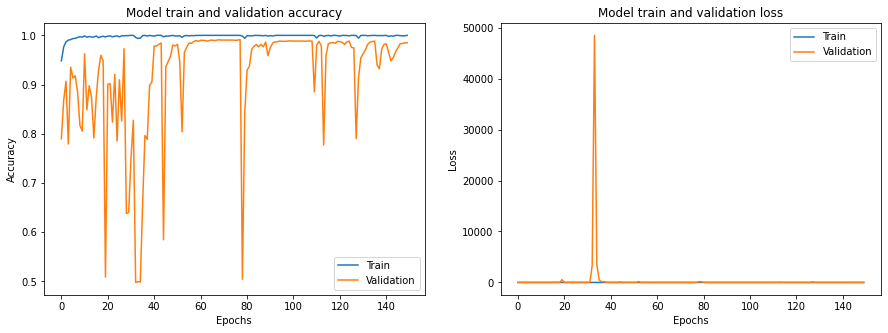

In [18]:
# Plotting the loss and accuracy from the saved model history
fig,(ax,ay) =plt.subplots(1,2,figsize=(15,5))
ax.plot(hist_csv['epoch'],hist_csv['accuracy'],label='Train')
ax.plot(hist_csv['epoch'],hist_csv['val_accuracy'],label='Validation')
ax.set_title('Model train and validation accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()
ay.plot(hist_csv['epoch'],hist_csv['loss'],label='Train')
ay.plot(hist_csv['epoch'],hist_csv['val_loss'],label='Validation')
ay.set_title('Model train and validation loss')
ay.set_xlabel('Epochs')
ay.set_ylabel('Loss')
ay.legend()
plt.show

#  Noisy Model

In [19]:
def add_noise(img):
    var = 50
    deviation = var*np.random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    img=preprocess_input(img)
    return img
# the above code was mainly taken from stackoverflow

noisy_aug=ImageDataGenerator(preprocessing_function=add_noise)

train = noisy_aug.flow_from_directory('/content/Hurricane/train', target_size=(224, 224),class_mode='binary',shuffle='False')
val = noisy_aug.flow_from_directory('/content/Hurricane/validation/', target_size=(224, 224),class_mode='binary',shuffle='False')
test_another = noisy_aug.flow_from_directory('/content/Hurricane/test_another/', target_size=(224, 224),class_mode='binary',shuffle='False')
test=noisy_aug.flow_from_directory('/content/Hurricane/test',target_size=(224, 224),class_mode='binary',shuffle='False')


Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


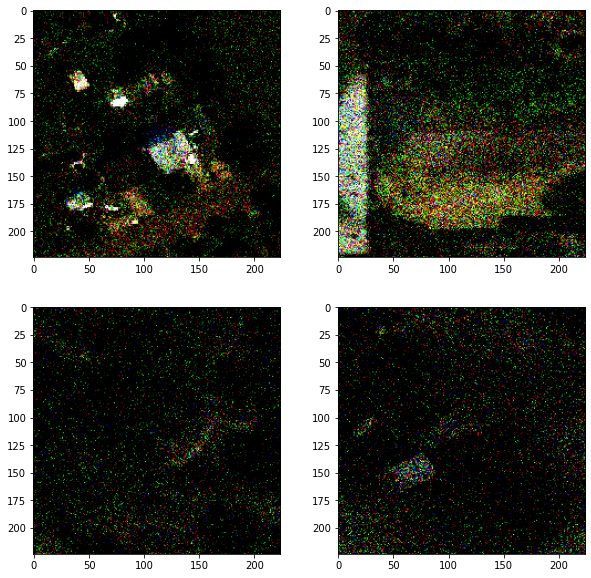

In [20]:
#Displaying some noisy images
fig,ax=plt.subplots(2,2,figsize=(10,10))
for i,ax in enumerate(ax.ravel()):
    ax.imshow(test_another[0][0][i+17]*2)

In [21]:
#getting the best noisy model and its history
if os.path.exists('best_model_noise.h5')==False:
    !gdown --id 1AICyFgHU42Cpdmm9g8z8DQd-GxOFW1f7 # noisy model
    !gdown --id 1NqsA1VkCmQA78bQbkjuqaVZDjqhlm_RS  # noisy history
clear_output()

In [22]:
if os.path.exists('best_model_noise.h5')==False:
    base_model=NASNetMobile(include_top=False,weights='imagenet') #initializing imagenet weights and removing the Dense layers
    for layer in base_model.layers[:500]:  # Freezing first 500 layers as they would be better at getting the basic shapes
        layer.trainable=False
# Adding some layers to make a sense of the patterns picked up by the Convolution layers
    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dense(1056,activation='relu',kernel_regularizer='l2')(x)
    x=Dense(1056,activation='relu')(x)
    x=Dropout(0.4)(x)
    x=Dense(512,activation='relu')(x)
    out=Dense(1,activation='sigmoid')(x) 
    mc = ModelCheckpoint('best_model_noise.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    hist = tf.keras.callbacks.CSVLogger('log-noise.csv', separator=",", append=False) #Saving the History

    model_t=Model(inputs=base_model.input,outputs=out)
    model_t.summary()
    model_t.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
#Fitting the model with validation data, 50 epochs and callbacks
if os.path.exists('best_model_noise.h5')==False:  
    step_size_train=train.n//train.batch_size
    step_size_validation=val.n//val.batch_size
    history_n=model_t.fit(train,steps_per_epoch=step_size_train,validation_data=val,validation_steps=step_size_validation,epochs=50,callbacks=[mc,hist])

In [24]:
if os.path.exists('best_model_noise.h5')==False:
    fig,(ax,ay)=plt.subplots(1,2,figsize=(17,10))
    ax.plot(history_n.history['accuracy'])
    ax.plot(history_n.history['val_accuracy'])
    ax.set_title('model accuracy')
    ax.set_ylabel('accuracy')
    ax.set_xlabel('epoch')
    ax.legend(['train', 'test'], loc='upper left')

    ay.plot(history_n.history['loss'])
    ay.plot(history_n.history['val_loss'])
    ay.set_title('model loss')
    ay.set_ylabel('loss')
    ay.set_xlabel('epoch')
    ay.legend(['train', 'test'], loc='upper left')
    plt.savefig('accuracy_loss.jpeg')
    plt.show()

# Loading the saved noisy model

In [25]:
# Noisy data evaluation
noisy_model = load_model('best_model_noise.h5')
# Loading the history of the noisy model
hist_csv_n=pd.read_csv('log-noise.csv')
# And evaluating its performance
eval_test_n=noisy_model.evaluate(test)
eval_test_another_n=noisy_model.evaluate(test_another)
print('Loss on unbiased data =',np.round(eval_test_n[0],3),'Accuracy of unbiased data=',np.round(eval_test_n[1],3))
print('Loss on biased data =',np.round(eval_test_another_n[0],3),'Accuracy of biased data=',np.round(eval_test_another_n[1],3))

282/282 [==============================] - 57s 201ms/step - loss: 0.2682 - accuracy: 0.9648
Loss on unbiased data = 0.105 Accuracy of unbiased data= 0.984
Loss on biased data = 0.268 Accuracy of biased data= 0.965


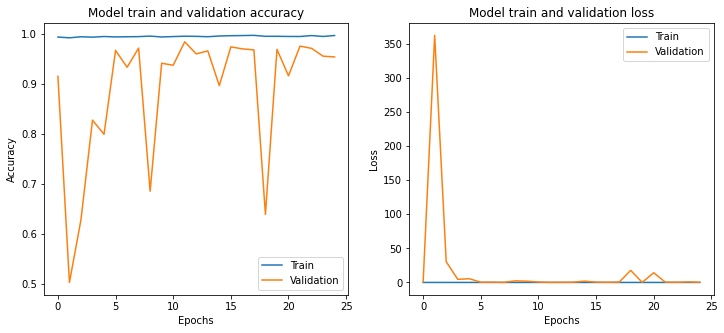

In [26]:
# Plotting the loss and accuracy from the saved model history
fig,(ax,ay) =plt.subplots(1,2,figsize=(12,5))
ax.plot(hist_csv_n['epoch'],hist_csv_n['accuracy'],label='Train')
ax.plot(hist_csv_n['epoch'],hist_csv_n['val_accuracy'],label='Validation')
ax.set_title('Model train and validation accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()

ay.plot(hist_csv_n['epoch'],hist_csv_n['loss'],label='Train')
ay.plot(hist_csv_n['epoch'],hist_csv_n['val_loss'],label='Validation')
ay.set_title('Model train and validation loss')
ay.set_xlabel('Epochs')
ay.set_ylabel('Loss')
ay.legend()